In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import sckit for data preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  RobustScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
#import sckit unsupervised
from sklearn.cluster import KMeans, DBSCAN
#import sckit supervised
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
#import sckit metrics and miscellaneous
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

**Import data**

In [15]:
#Imports patient 1 dataframe. 
df_orig = pd.read_csv("./patients_01.csv")

raw_df = df_orig.copy()
raw_df = raw_df.dropna()
#Converts specified columns to strings and lists relevant columns names depending on the data type.
raw_df[["history_stroke","walking_diff", "disease"]] = raw_df[["history_stroke","walking_diff", "disease"]].astype(str)
cat_features = raw_df.select_dtypes(include='object').columns.tolist()
num_features = raw_df.select_dtypes(include=["float64","int64"]).columns.tolist()

In [16]:
#Apply modifications removing non-sensical values (eg. BMI cannot be 0)
raw_df = raw_df[raw_df["bmi"] > 0]

### **Pre-processing and Descriptive analysis**

Here data is plotted on heatmap to determine whether there are some patterns in missing data to decide on missing data handling strategy. As it can be seen, highly missing pattern in smoking suggests a data not missing at random.  

Text(0.5, 1.0, 'Representations of missing values')

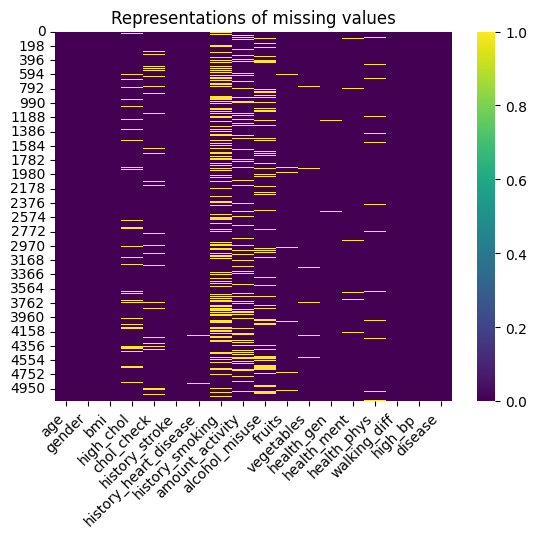

In [4]:
#Create a heatmap showing in yellow missing data
ax = sns.heatmap(df_orig.isnull(), cmap="viridis")
# Turns column names on the x axis.
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title("Representations of missing values")

**Imputation strategy**

*Numerical values*

For numerical value Simple Imputation with the mean was deemed a successful route. This is because Simple Imputers have been found to perform quite well with strong learners (as further down the line it was decided that Random Forest and Decision Trees will be used. These are models considered to be strong, as they both show the ability of capturing complex relationships in data. 

Using SimpleImputer() method where data is missing at random, in combination with strong models (eg. RandomForestClassifier or DecisionTreeCLassifier), results in predictive outcomes which generally outperform models trained with data imputed using stronger imputation techniques KNNImputer or IterativeImputer. Hence, using this imputation strategy in combination with previously stated models is a valid route to take. 

*Categorical variables*

As plot of missing data shows that  many more datapoints are missing in the in the category “smoker”. As there is a significant missing trend in this category compared to other categories, these data are imputed as “missing” as there is likely to be a undergoing trend in the missing data. This because it is likely that these data are not missing at random and there might be an underlying pattern (eg. lower age people are not comfortable saying they are smoking). 

The data frame is then forced to drop na for all other missing at random variables, as they do not show a patters of missingness (Missing at random, do not hold any statistical significance).

In [17]:
def SimpleImputationEncoding(df_raw_init, categories="pass",numerical="pass"):
    df_raw = df_raw_init.copy()
    #If different sets of categories and numerical features are passed, those are used in the imputation. 
    if categories !="pass" and numerical !="pass": 
        bias_features = ["history_smoking"]
        unbias_cfeatures = categories
        unbias_nfeatures = numerical
        df_raw[unbias_nfeatures] = df_raw.loc[:,unbias_nfeatures].astype(float, errors="ignore").copy()
        df_raw[bias_features] = df_raw.loc[:,bias_features].astype(str, errors="ignore").copy()
        
        #Imputes values as missing and encodes them with Label encoder (manual use)
        df_raw[bias_features] = SimpleImputer(strategy="constant", fill_value="missing").fit_transform(df_raw[bias_features])
        #df_imputed[bias_features] = LabelEncoder().fit_transform( df_imputed[bias_features])
        df_raw[bias_features] = df_raw.loc[:,bias_features].apply(lambda col: LabelEncoder().fit_transform(col))

        #Imputes values as mean and scales them with increased robustness to outliers.
        df_raw[unbias_nfeatures] = SimpleImputer(strategy="mean").fit_transform(df_raw[unbias_nfeatures])
        df_raw[unbias_nfeatures] = RobustScaler().fit_transform(df_raw[unbias_nfeatures])
        #Removes na from remaining categorical values and encodes the unbias features.
        df_raw.dropna()
        df_raw[unbias_cfeatures] = df_raw.loc[:,unbias_cfeatures].apply(lambda col: LabelEncoder().fit_transform(col))

        # further removes trailing NAs
        return df_raw.dropna()
    
    #if no categories and numerical are passed, then use default feature names. 
    else: 
        bias_features = ["history_smoking"]
        unbias_cfeatures = ['gender', 'high_chol', "walking_diff",'chol_check', 'history_stroke', 'history_heart_disease', 'amount_activity', 'fruits', 'vegetables', 'high_bp']
        unbias_nfeatures = ['age', 'bmi', 'health_gen', 'health_ment', 'health_phys',"alcohol_misuse"]
        df_raw[unbias_nfeatures] = df_raw.loc[:,unbias_nfeatures].astype(float, errors="ignore").copy()
        df_raw[bias_features] = df_raw.loc[:,bias_features].astype(str, errors="ignore").copy()
        
        #Imputes values as missing and encodes them with Label encoder (manual use)
        df_raw[bias_features] = SimpleImputer(strategy="constant", fill_value="missing").fit_transform(df_raw[bias_features])
        #df_imputed[bias_features] = LabelEncoder().fit_transform( df_imputed[bias_features])
        df_raw[bias_features] = df_raw[bias_features].apply(lambda col: LabelEncoder().fit_transform(col))

        #Imputes values as mean and scales them with increased robustness to outliers.
        df_raw[unbias_nfeatures] = SimpleImputer(strategy="mean").fit_transform(df_raw[unbias_nfeatures])
        df_raw[unbias_nfeatures] = RobustScaler().fit_transform(df_raw[unbias_nfeatures])
        #Removes na from remaining categorical values and encodes the unbias features.
        df_raw.dropna()
        df_raw[unbias_cfeatures] = df_raw.loc[:,unbias_cfeatures].apply(lambda col: LabelEncoder().fit_transform(col))

        
        return df_raw.dropna()

#Train and test are used for initial supervised learning testing and exploring. 
train_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df["disease"])
train_imputed = SimpleImputationEncoding(train_df)
test_imputed = SimpleImputationEncoding(test_df)

#Whole dataframe is used for unsupervised learning.
whole_cfeatures = ['gender', 'high_chol', "walking_diff",'chol_check', 'history_stroke', 'history_heart_disease', 'amount_activity', 'fruits', 'vegetables', 'high_bp', "disease"]
whole_nfeatures = ['age', 'bmi', 'health_gen', 'health_ment', 'health_phys',"alcohol_misuse"] 
imputed_df = SimpleImputationEncoding(raw_df, categories=whole_cfeatures, numerical=whole_nfeatures)

In [18]:
print(raw_df)

      age  gender  bmi high_chol chol_check history_stroke  \
0      68  female   20    normal    checked          False   
1      54  female   47    normal    checked          False   
2      55  female   30    normal    checked          False   
8      39  female   26    normal    checked          False   
10     40    male   31    normal    checked          False   
...   ...     ...  ...       ...        ...            ...   
5104   53  female   22    normal    checked          False   
5107   47  female   34    normal    checked          False   
5109   59    male   27    normal    checked          False   
5117   84  female   18    normal    checked           True   
5123   21  female   21    normal    checked          False   

     history_heart_disease history_smoking amount_activity  alcohol_misuse  \
0                    False           False          active             2.0   
1                    False            True          active             1.0   
2                    

In [ ]:
sns.pairplot(train_df, hue="disease")


C:\Users\marce\AppData\Local\Temp\ipykernel_13284\1098101446.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = pandas_df.corr()


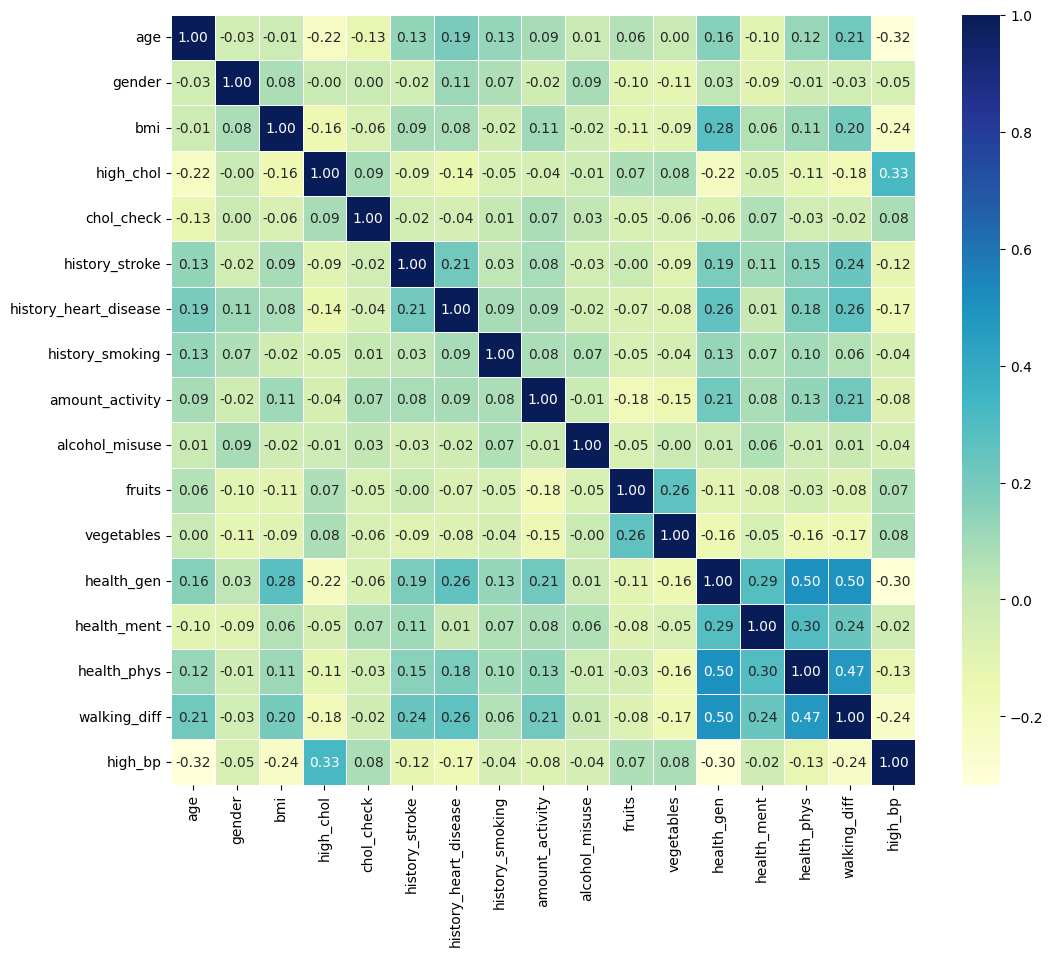

In [19]:
# Correlation is: positive(greater than 0), negative(less than zero), not correlated (0)
def corr_mx(pandas_df):
    #Calculates correlation scores
    correlation_matrix = pandas_df.corr()
    # Create correlation matrix plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5)
    plt.show()

#Corr matrix calling. Keep in mind that rows with missing values are automatically removed when determining a correlation matrx
corr_mx(train_imputed)

### **Unsupervised learning**

Due to multivariate nature of data, PCA is carried out to reduce dimensionality of data whilst preserving meningful relationships. This results into principal components, which are the orthogonal linear combinations of the original variables in a dataset. This results in values which allow plotting on a 2D graph, resulting into clusters based on multi-dimensional data.
KMeans is an unsupervised learning technique used to cluster datapoints based on their distance from the nearest mean (centroid)  and initiate hypothesis formulation.
Kmeans results are then overlayed on the PCA plot to identify data clusters.

Further dimensionality reductions techniques were investigated. tSNE and UMAP, albeit mathematically different, operate on the same major non-linear capturing concept (explain better). This results in capturing of non linear relationships, which is better suited in dimensionality reduction for multivariate data with non-linear relationship. As it can be seen, tSNE and UMAP generate more visually distinct clusters when compared to PCA, suggesting that some non-linear relationships between variables can be involved in determining the disease. 


To determine best number of neighbours for KMeans, elbow plot highligting decrease of *Sum of squared distances* of samples to their closest cluster centre with different neighbours numbers is carried out. 


Text(0.5, 1.0, 'UMAP of patient 1 dataset')

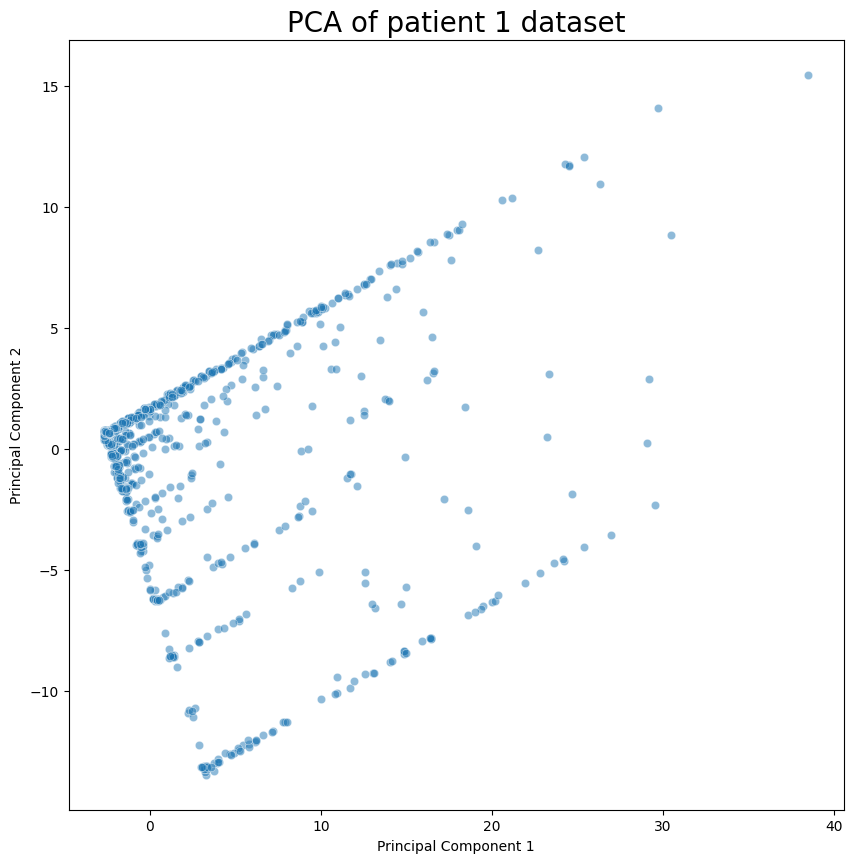

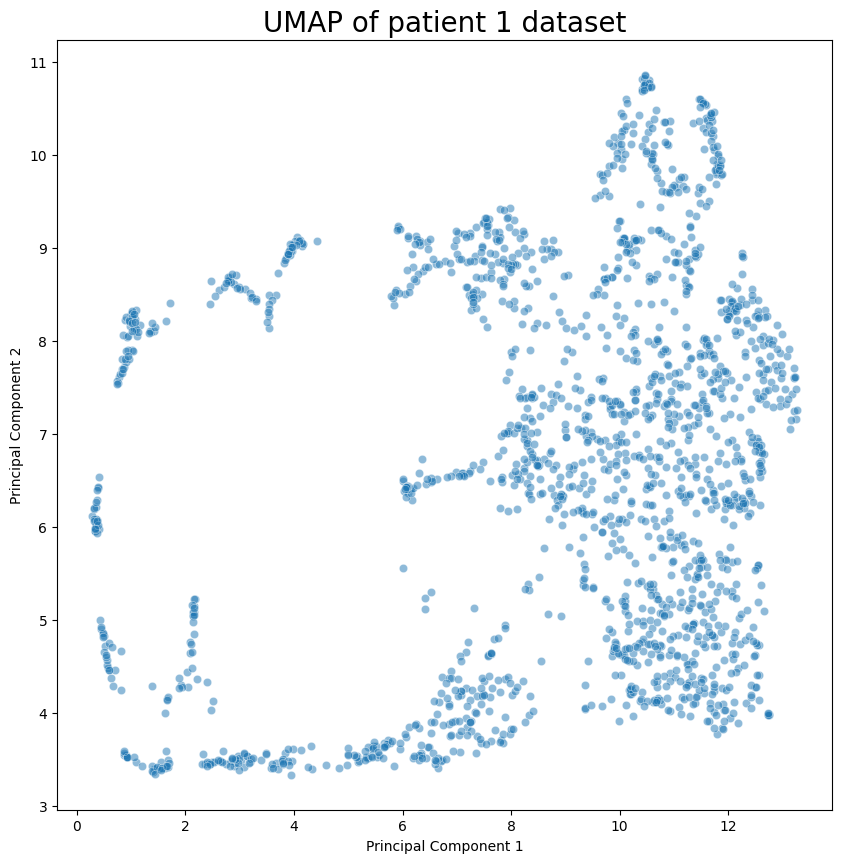

In [20]:
#Dimension reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
#Defines n of components in the PCA, applies dimensionality reduction on whole dataset
#stores PCA results in dataframe and plots PC1 against PC2. 
pca = PCA(n_components=2)
PCA_whole = pd.DataFrame(pca.fit_transform(imputed_df.iloc[:,:-1]))
PCA_whole["Disease"] = imputed_df.iloc[:,-1]
PCA_whole.columns = ["Principal Component 1", "Principal Component 2", "Disease"]
plt.figure(figsize = (10,10))
     #first plot the data point themselves - use gray points
ax = sns.scatterplot(x="Principal Component 1", y="Principal Component 2",data=PCA_whole ,alpha=0.5)
plt.title("PCA of patient 1 dataset", size=20)

#Use UMAP for dimension reduction 
umap = UMAP(n_components=2, random_state=42, n_jobs=1)
UMAP_whole = pd.DataFrame(umap.fit_transform(imputed_df.iloc[:,:-1]))
UMAP_whole["Disease"] = imputed_df.iloc[:,-1]
UMAP_whole.columns = ["Principal Component 1", "Principal Component 2", "Disease"]
plt.figure(figsize = (10,10))
     #first plot the data point themselves - use gray points
ax = sns.scatterplot(x="Principal Component 1", y="Principal Component 2",data=UMAP_whole, alpha=0.5)
plt.title("UMAP of patient 1 dataset", size=20)

KeyboardInterrupt: 

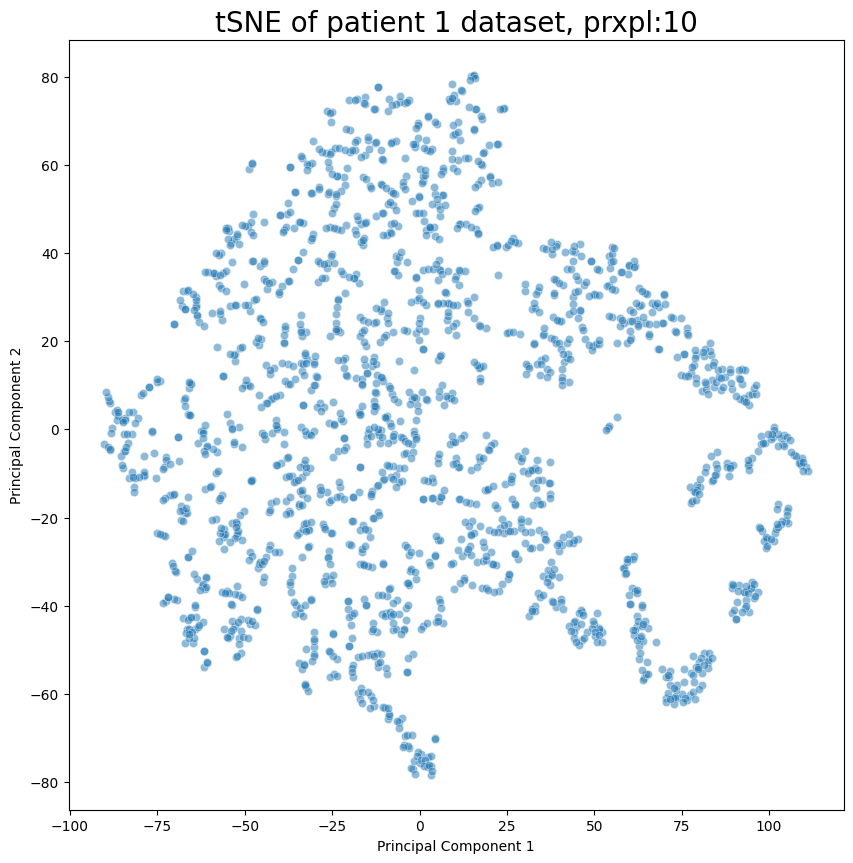

In [21]:
#tSNE for dimension reduction: multiple perplexity values are tested. Best separation given by 30.
for i in range (10,50,10): 
     tsne = TSNE(n_components=2,perplexity=i, random_state=42, n_iter=2000)
     Tsne_whole = pd.DataFrame(tsne.fit_transform(imputed_df.iloc[:,:-1]))
     Tsne_whole["Disease"] = imputed_df.iloc[:,-1]
     Tsne_whole.columns = ["Principal Component 1", "Principal Component 2", "Disease"]
     plt.figure(figsize = (10,10))
          #first plot the data point themselves - use gray points
     ax = sns.scatterplot(x="Principal Component 1", y="Principal Component 2",data=Tsne_whole, alpha=0.5)
     plt.title(f"tSNE of patient 1 dataset, prxpl:{i}", size=20)

In [ ]:
for seed in range (40,45):
    tsne = TSNE(n_components=2,perplexity=30, random_state=seed, n_iter=2000)
    Tsne_whole = pd.DataFrame(tsne.fit_transform(imputed_df.iloc[:,:-1]))
    Tsne_whole["Disease"] = imputed_df.iloc[:,-1]
    Tsne_whole.columns = ["Principal Component 1", "Principal Component 2", "Disease"]
    plt.figure(figsize = (10,10))
        #first plot the data point themselves - use gray points
    ax = sns.scatterplot(x="Principal Component 1", y="Principal Component 2",data=Tsne_whole,hue = "Disease", alpha=0.5)
    plt.title(f"tSNE of patient 1 dataset, seed:{seed} ", size=20)

Text(0.5, 1.0, 'tSNE of patient 1 dataset')

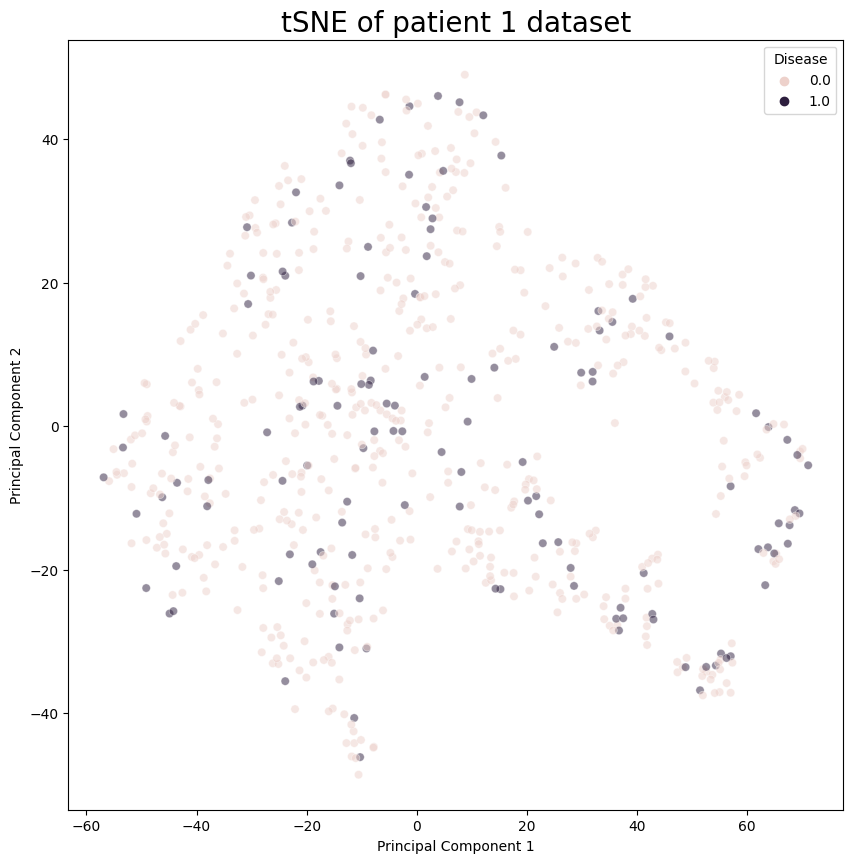

In [22]:
tsne = TSNE(n_components=2,perplexity=30, random_state=42, n_iter=2000)
Tsne_whole = pd.DataFrame(tsne.fit_transform(imputed_df.iloc[:,:-1]))
Tsne_whole["Disease"] = imputed_df.iloc[:,-1]
Tsne_whole.columns = ["Principal Component 1", "Principal Component 2", "Disease"]
plt.figure(figsize = (10,10))
    #first plot the data point themselves - use gray points
ax = sns.scatterplot(x="Principal Component 1", y="Principal Component 2",data=Tsne_whole,hue = "Disease", alpha=0.5)
plt.title(f"tSNE of patient 1 dataset", size=20)

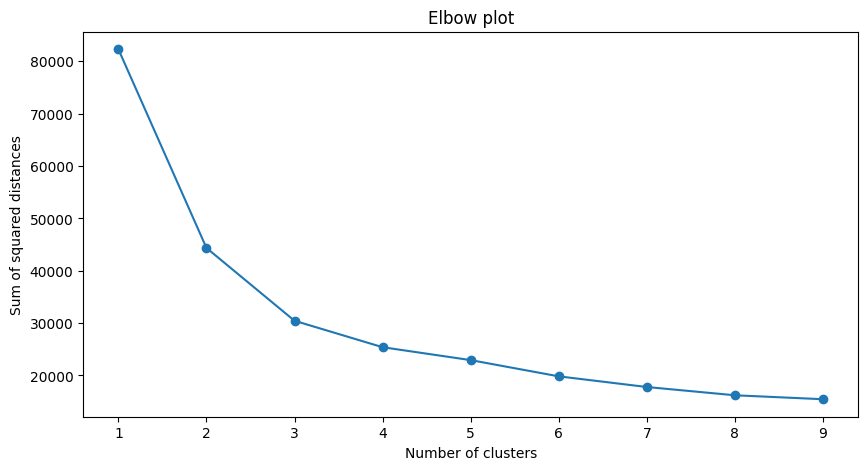

Text(0.5, 1.0, 'UMAP with KMeans labelling')

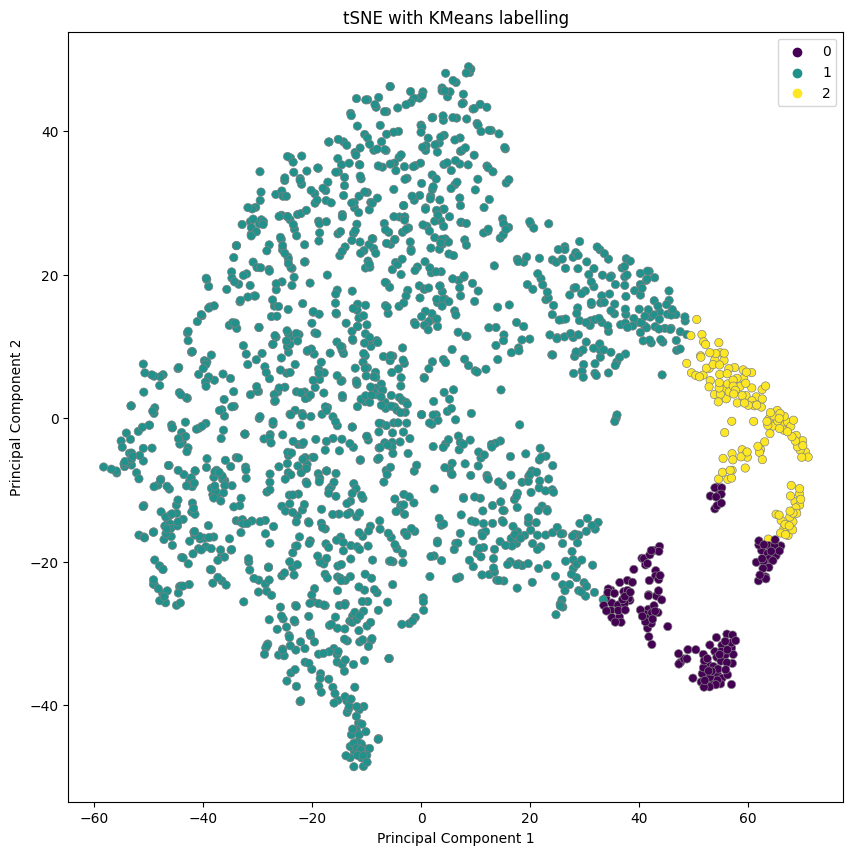

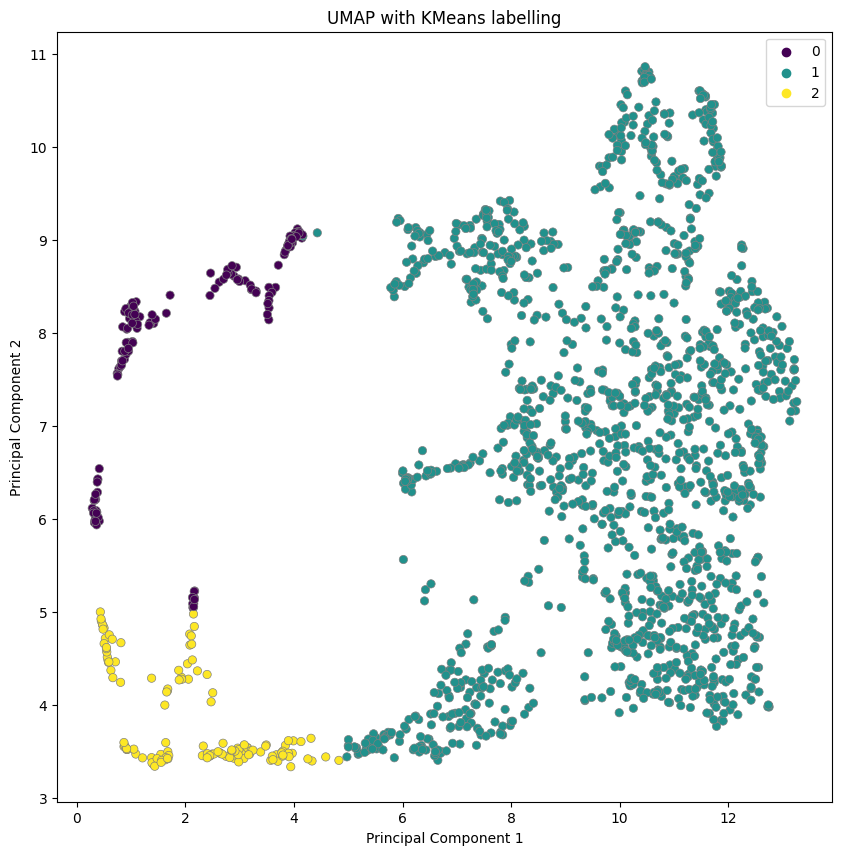

In [23]:
#Determines best k-value for KMeans plot using elbow plot. 
def Kmean_elbow(dataframe, cluster_max):
    means = []
    inertias = []
    for k in range(1,cluster_max):    
    #Computes KMeans algorithm
        kmeans = KMeans(n_clusters=k,n_init="auto", random_state=42).fit(dataframe)
        means.append(k)
        inertias.append(kmeans.inertia_)
    
    #Plots Elbow plot using inertia metric. 
    plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, "o-")
    plt.title("Elbow plot")
    plt.xlabel("Number of clusters")
    plt.ylabel("Sum of squared distances")
    plt.show()    
Kmean_elbow(imputed_df, 10)

#Layers KMeans output with best cluster_n on PCA plot as color. 
#Each color indicates one cluster 
k_out = KMeans(n_clusters=3, n_init="auto", random_state=42).fit(imputed_df.iloc[:,:-1])
centroids = k_out.cluster_centers_
cent_df = pd.DataFrame(centroids)

#Plot TSNE overlaying with clustering algorithms ouputs. 
plt.figure(figsize = (10,10))   
ax = sns.scatterplot(x="Principal Component 1", y="Principal Component 2",data=Tsne_whole ,hue=k_out.labels_, palette="viridis", edgecolor='grey')
plt.title("tSNE with KMeans labelling")

#Plot UMAP overlaying with clustering algorithms ouputs. 
plt.figure(figsize = (10,10))   
ax = sns.scatterplot(x="Principal Component 1", y="Principal Component 2",data=UMAP_whole ,hue=k_out.labels_, palette="viridis", edgecolor='grey')
plt.title("UMAP with KMeans labelling")

### **Supervised analysis**

Models tested to determine disease based on recorded features were: RandomForest Classifier, and DecisionTrees. 

Due to disease imbalances, training data where resampled to ensure a balanced classed for better training of model, resulting in better model generalization.

Strong over-representation of healthy individuals. Use of imbalanced API will allow to resample some "Unhealthy patient", balancing the classes in the dataset and allowing more accurate prediction.

Resampling to balance class imbalance has been carried out.

In [24]:
imputed_df["disease"].value_counts()

0    1512
1     344
Name: disease, dtype: int64

In [25]:
#Split imputed test/train dataframe. Stratification and imputation is inhereited from relative variables. 
OG_X_train = train_imputed.iloc[:,:-1]
OG_y_train = train_imputed["disease"]
X_test = test_imputed.iloc[:,:-1]
y_test = test_imputed["disease"]

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(OG_X_train, OG_y_train)
print(y_train.value_counts())

#DO THIS WITH MULTIPLE MODELS SO YOU HAVE GROUND FOR DISCUSSION
    #Choose a model  (RandomForest deals well with encoded data)
    #Tune hyperparameters
    #Train model 
    #Carry out stratified crossvalidation 
    #Test data label prediction
    #Model evaluation: Produce confusion matrix, calculate different scores describing model validity (F1, accuracy,...).  

False    1209
True     1209
Name: disease, dtype: int64


In [26]:
#STRATIFIED MODEL EVALUATION function: 
def strat_valid(X_frame, Y_frame, model, categories="pass", numerical="pass"):
    
    # Defines number of folds. 
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    #Defines lists to store fold index (k_list). Other lists store corresponding metrics scores.
    k_list = []
    acc_score = []
    f1_score_list = []
    prec_list = []
    recall_list = []
    #Loops over stratifications for both train and test data.
    for count_k,(train_index, test_index) in enumerate(kf.split(X_frame, Y_frame)):

        #Defines new train/test datasets. 
        OG_X_train = X_frame.iloc[train_index]
        X_test  = X_frame.iloc[test_index]
        OG_y_train = Y_frame.iloc[train_index]
        y_test  = Y_frame.iloc[test_index]

        #Fixes y-variable imbalance by randomly resampling lower classes.
        
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(OG_X_train, OG_y_train)

        #Imputes and transform data at each K fold for the dataframes.
        X_train_imp = SimpleImputationEncoding(X_train, categories, numerical)
        y_train_enc = LabelEncoder().fit_transform(y_train)
        X_test_imp = SimpleImputationEncoding(X_test, categories, numerical)
        y_test_enc = LabelEncoder().fit_transform(y_test)
        
        #Trains and Predicts using the defined model.  
        dtree = model.fit(X_train_imp,y_train_enc)
        y_predicted = dtree.predict(X_test_imp)
        
        #Defines variables for scores a
        accuracy = accuracy_score(y_test_enc,y_predicted)
        f1 = f1_score(y_test_enc,y_predicted, average="weighted")
        precision = precision_score(y_test_enc,y_predicted, average="weighted")
        recall = recall_score(y_test_enc,y_predicted, average="weighted")
        #conf_max = confusion_matrix(y_test,y_test_predicted)

        #For each stratification print k-fold number and confusion matrix by comparing predicted label with actual label. 
        print(f'Fold run (k={count_k})')
        k_list.append(count_k)
        ConfusionMatrixDisplay.from_predictions(y_test_enc, y_predicted)
        plt.figure(figsize=(1,1))
        plt.show()
        #Appends metrics value to respective list. 
        acc_score.append(accuracy)
        f1_score_list.append(f1)
        prec_list.append(precision)
        recall_list.append(recall)
    #Creates output performance metrics dataframe.
    metrics_df = pd.DataFrame(columns=["Count_k","Accuracy_score", "F1 score", "Precision score"])
    metrics_df["Count_k"] = k_list
    metrics_df["Accuracy_score"] = acc_score
    metrics_df["F1 score"] = f1_score_list
    metrics_df["Precision score"] = prec_list
    metrics_df["Recall score"] = recall_list

    #returns a dataframe with all the metrics ordered by k-fold. 
    return metrics_df

**Random Forest classifier**

Factors considered during model choice.

*Analysis goal:* predict whether a patient with some observed metabolic features has a disease or not.

*Model complexity:* a complex model is required due to multivariate origin of the problem. Furthermore, as part of the data is likely missing not at random, RandomForest classifier is capabel of handling complex dataset with missing values encoded as such.  This is due to:

  + Non-Parametric nature: doesnt make assumptions about data distribution. 
  + Ensemble based model: uses multiple trees and uses the most likely outcome
  + Robust to noise: using multiple trees.
  + Non-Linear relationships: as it is an ensemble model, RandomForestClassifier is capable of capturing non linear relationships, making it more suitable for this analysis, as seen by running tSNE and UMAP. 

*Scalability and training time:* O(k * m * n * log(n)), results in longer training time. To be noted it can be parallelized grwoing each tree indipendently, which noteceably speeds up the process. In this coursework, training time did play a big factors in model choice, due to dataset size being relatively small (~3840 samples after imputation and splitting).

*Other factors:* Chosen as it classifies data and deals well with encoded data. 

In [27]:
#Using the RandomForestClassifier
#Finds best hyper-parameters 
parameters = {
    'criterion':('gini', 'entropy'), 
    'max_depth':[1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf':[2,5,6,7,8,10,11]
}
#define RandomForest model and determine best hyperparameters with GridSearchCV. Random state is set to allow result reproduceability. 
pines = RandomForestClassifier(random_state=42)
pines.fit(X_train,y_train)
pines_gsearch = GridSearchCV(pines, parameters, cv=5,scoring='balanced_accuracy') # weighted == F1 Measure for multi-class
grid_search = pines_gsearch.fit(X_train, y_train)

#Outputs best parameter from grid search estimation. 
pines_gsearch.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=2, random_state=42)

accuracy_score: 0.8306451612903226
Fold run (k=0)


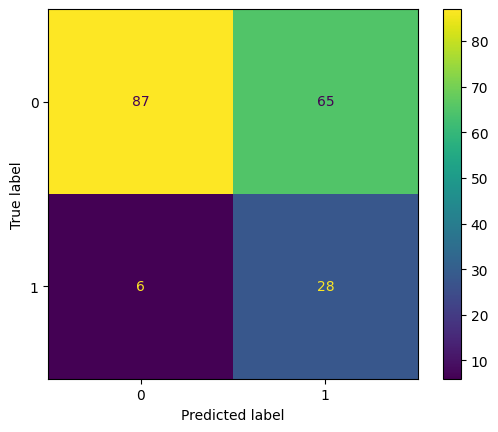

<Figure size 100x100 with 0 Axes>

Fold run (k=1)


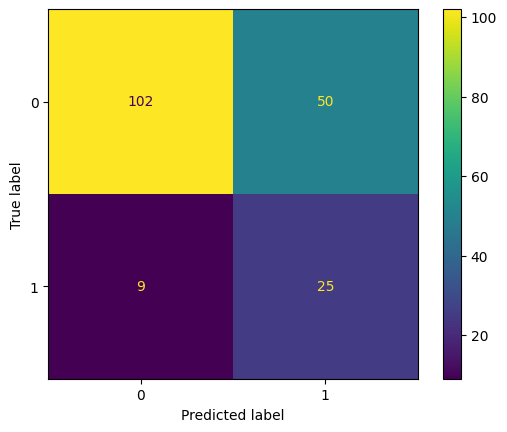

<Figure size 100x100 with 0 Axes>

Fold run (k=2)


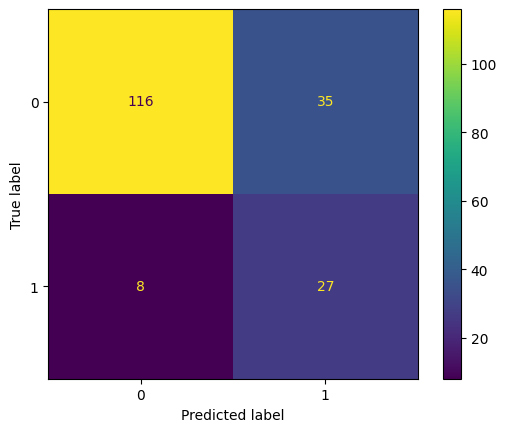

<Figure size 100x100 with 0 Axes>

Fold run (k=3)


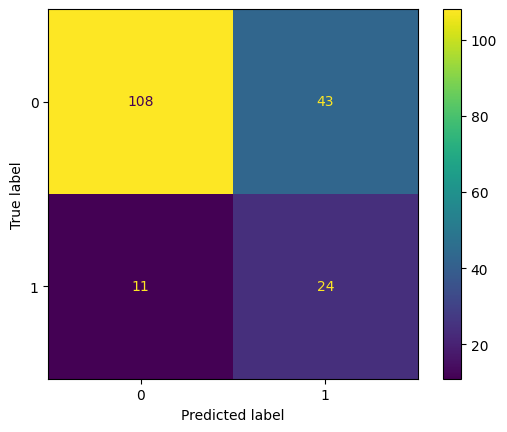

<Figure size 100x100 with 0 Axes>

Fold run (k=4)


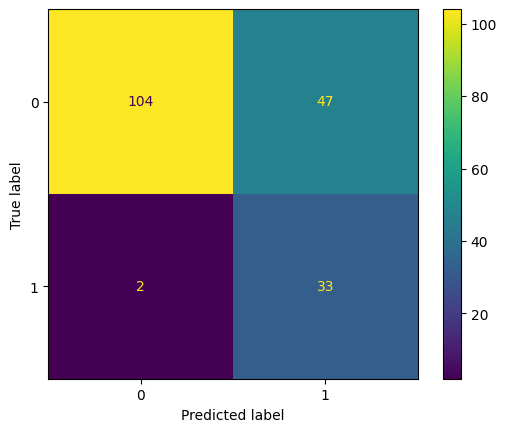

<Figure size 100x100 with 0 Axes>

Fold run (k=5)


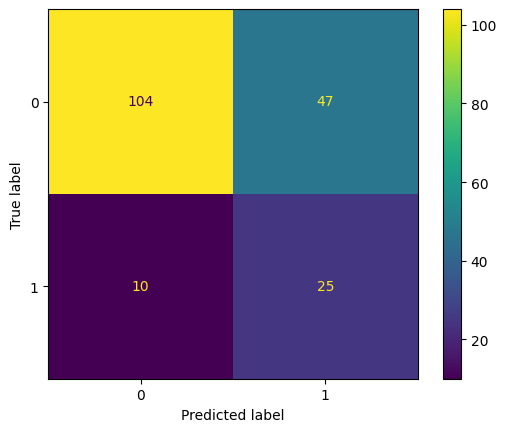

<Figure size 100x100 with 0 Axes>

Fold run (k=6)


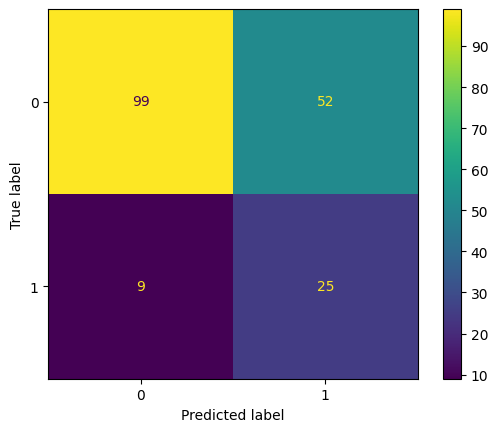

<Figure size 100x100 with 0 Axes>

Fold run (k=7)


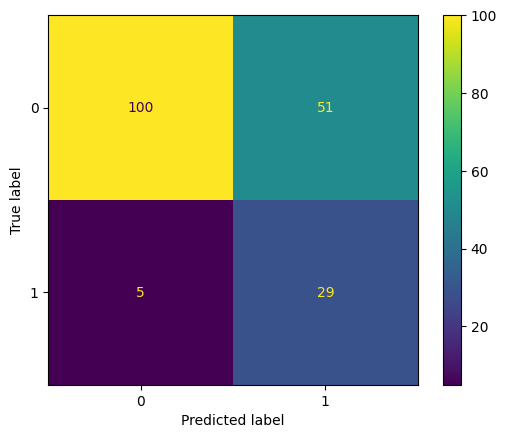

<Figure size 100x100 with 0 Axes>

Fold run (k=8)


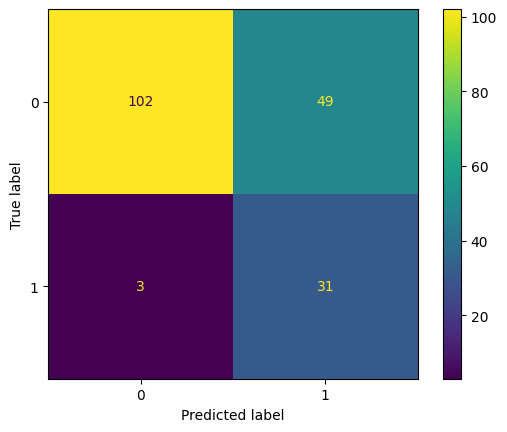

<Figure size 100x100 with 0 Axes>

Fold run (k=9)


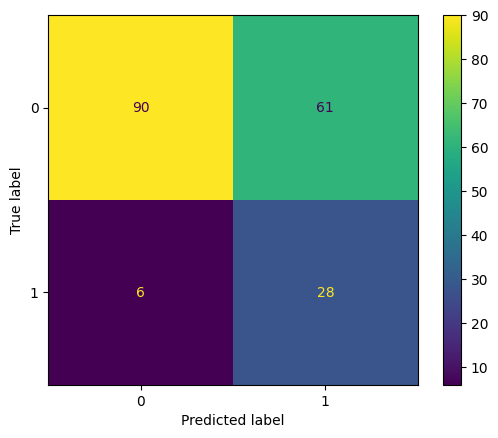

<Figure size 100x100 with 0 Axes>

   Count_k  Accuracy_score  F1 score  Precision score  Recall score
0        0        0.618280  0.660985         0.819517      0.618280
1        1        0.682796  0.717728         0.811876      0.682796
2        2        0.768817  0.789643         0.841398      0.768817
3        3        0.709677  0.738014         0.804190      0.709677
4        4        0.736559  0.765038         0.874131      0.736559
5        5        0.693548  0.725139         0.805952      0.693548
6        6        0.670270  0.706765         0.807868      0.670270
7        7        0.697297  0.731173         0.843970      0.697297
8        8        0.718919  0.750375         0.864112      0.718919
9        9        0.637838  0.678487         0.823022      0.637838


In [28]:
#Train model with tuned hyperparameters. Random state is set to 42 for reproducibility (and because it's the answer to everything in the universe). 
pines = RandomForestClassifier(criterion="entropy",max_depth=10,min_samples_leaf=2,random_state=42)
pines.fit(X_train,y_train)
#Predicts label values 
y_test_predicted = pines.predict(X_test)
print(f"accuracy_score: {accuracy_score(y_test, y_test_predicted)}")

#Defines feature and prediction dataframes to initizialize a Stratified K fold simulation. 
X = raw_df.iloc[:,:-1]
y = raw_df["disease"]
#Carrys out model evaluation and outputs metrics in a dataframe. 
metrics_RFC = strat_valid(X,y,pines)
print(metrics_RFC)

Text(0.5, 0, 'Feature importance')

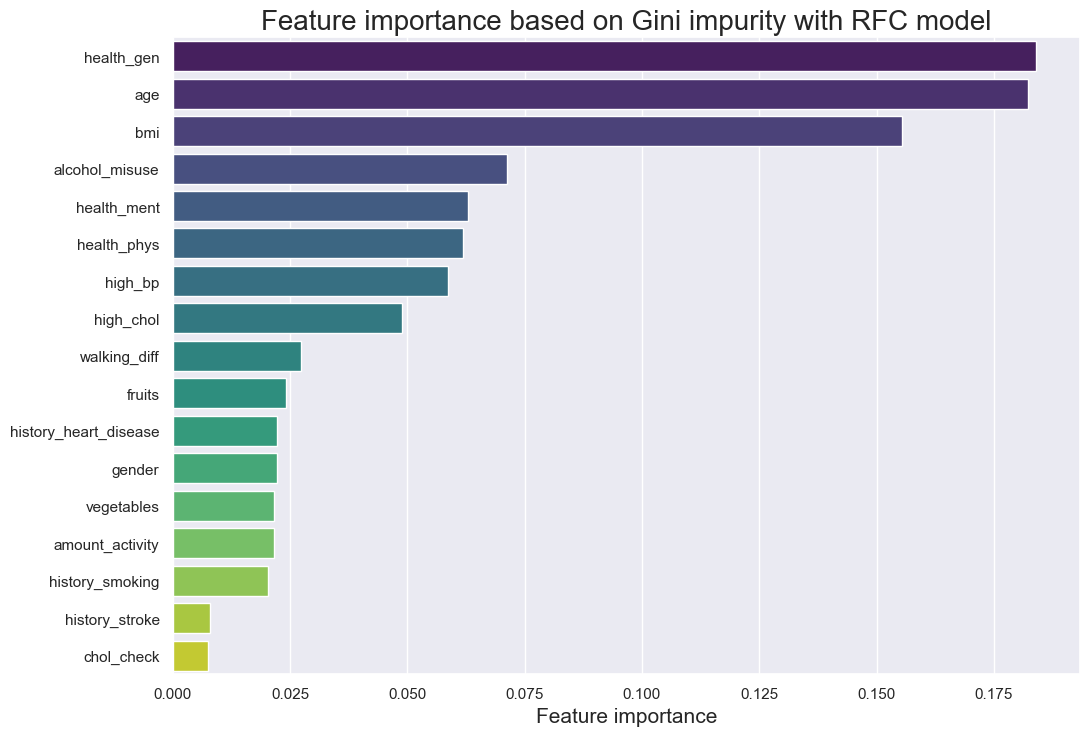

In [29]:
#Determines feature importance based on RFC model. 
ft_import = pines.feature_importances_

#Sorts features from most important to least important.
sorted_idx = ft_import.argsort()[::-1]
name_sort = imputed_df.columns[sorted_idx]
importa_sort = ft_import[sorted_idx]

#Plot importances based on gini impurity. 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=importa_sort, y=name_sort, palette="viridis")
plt.title("Feature importance based on Gini impurity with RFC model", fontsize= 20)
plt.xlabel("Feature importance", fontsize= 15)

**Removing most important feature from RandomForestClassifier**

According to previous analysis it is General health feature. 

In [ ]:
parameters = {
    'criterion':('gini', 'entropy'), 
    'max_depth':[1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf':[2,5,6,7,8,10,11]
}
#define RandomForest model and determine best hyperparameters with GridSearchCV. Random state is set to allow result reproduceability. 
pines = RandomForestClassifier(random_state=42)
pines.fit(X_train.drop(columns=["health_gen"]),y_train)
pines_gsearch = GridSearchCV(pines, parameters, cv=5,scoring='balanced_accuracy') # weighted == F1 Measure for multi-class
grid_search = pines_gsearch.fit(X_train, y_train)

#Outputs best parameter from grid search estimation. 
pines_gsearch.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=2, random_state=42)

As it can be seen below, removing health_gen feature results in overall improvement in model accuracy. Although counterintuitive, this can be expected in some scenarios. For instance, as RandomForestsClassifiers are prone to overfitting in case of excessive trees amounts, removing the variable that causes could result in improvement of the model. In this case, the most important variable could be causing overfitting resulting in model improvement in case of removal.  

Furthermore, the removed feature could be adding noise to the model, and its removal would result in better generalization of the model. 

To further improve the model, less relevant variables could be removed (eg. 'chol_check','fruits', 'vegetables'), resulting in better model fitting. 

As multiple features are dropped, the average recall score improves by ~10%. This suggests that not all features are involved in predicting diseases and that they add noise to the model.  

Fold run (k=0)


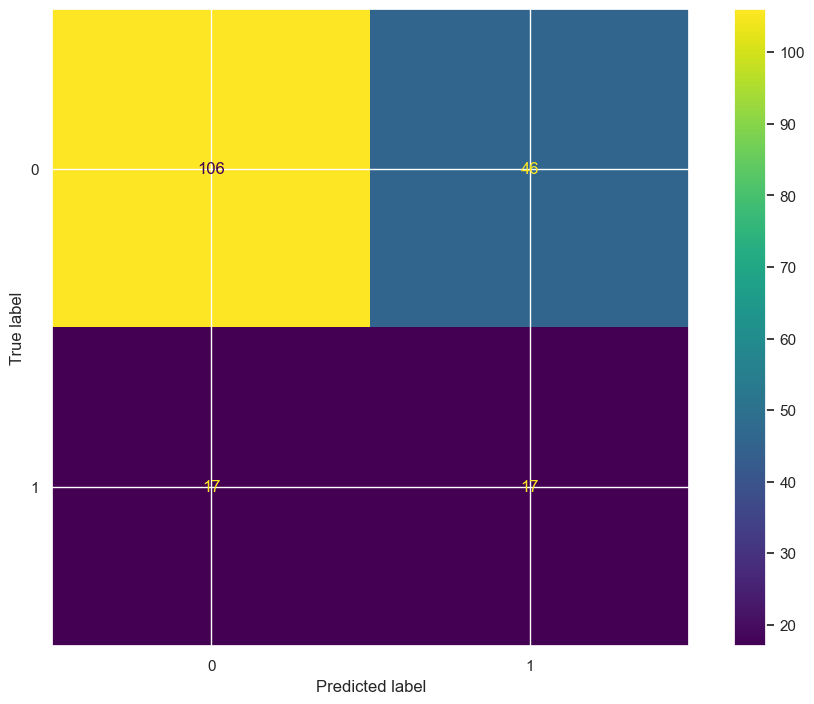

<Figure size 100x100 with 0 Axes>

Fold run (k=1)


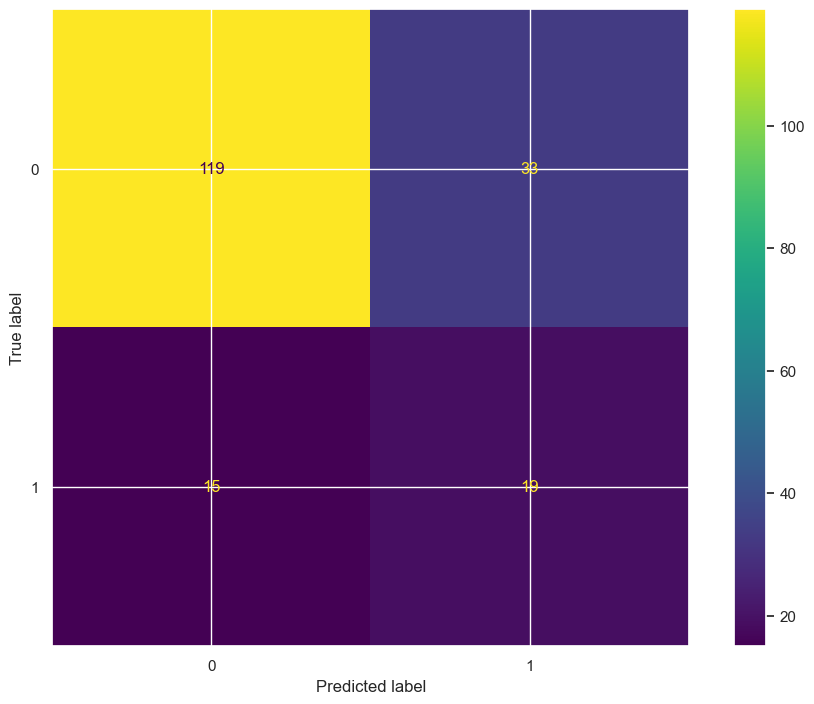

<Figure size 100x100 with 0 Axes>

Fold run (k=2)


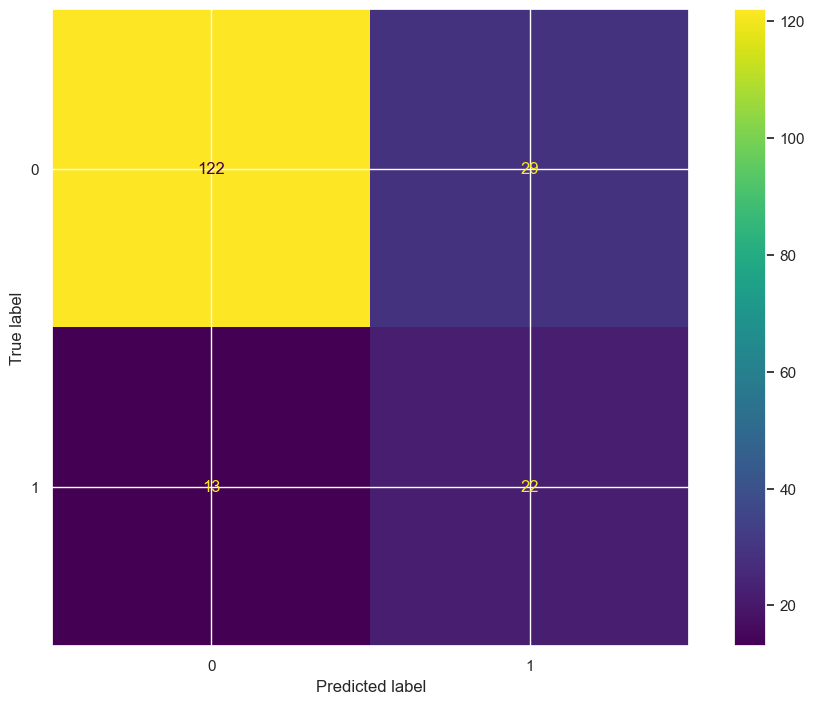

<Figure size 100x100 with 0 Axes>

Fold run (k=3)


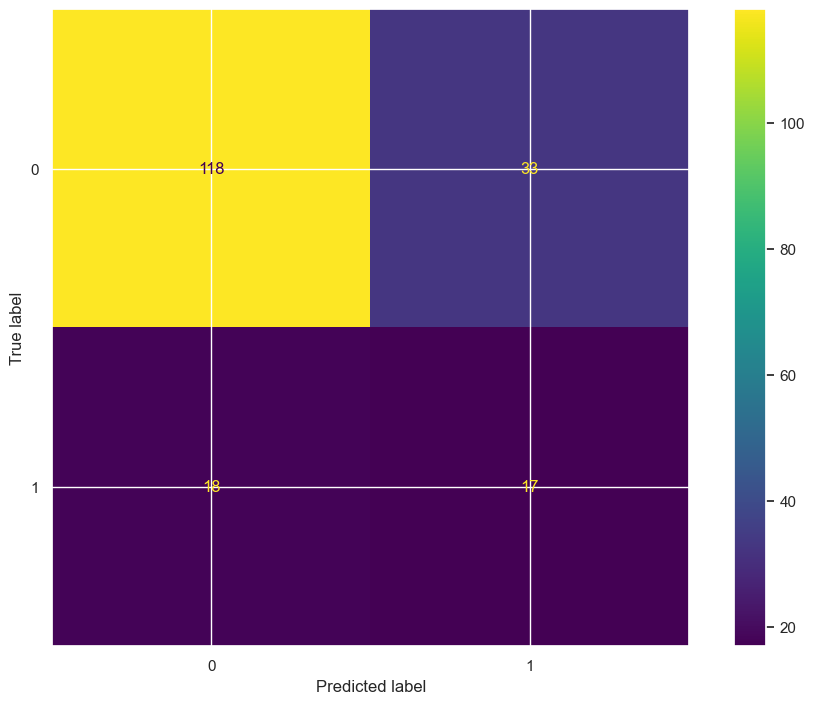

<Figure size 100x100 with 0 Axes>

Fold run (k=4)


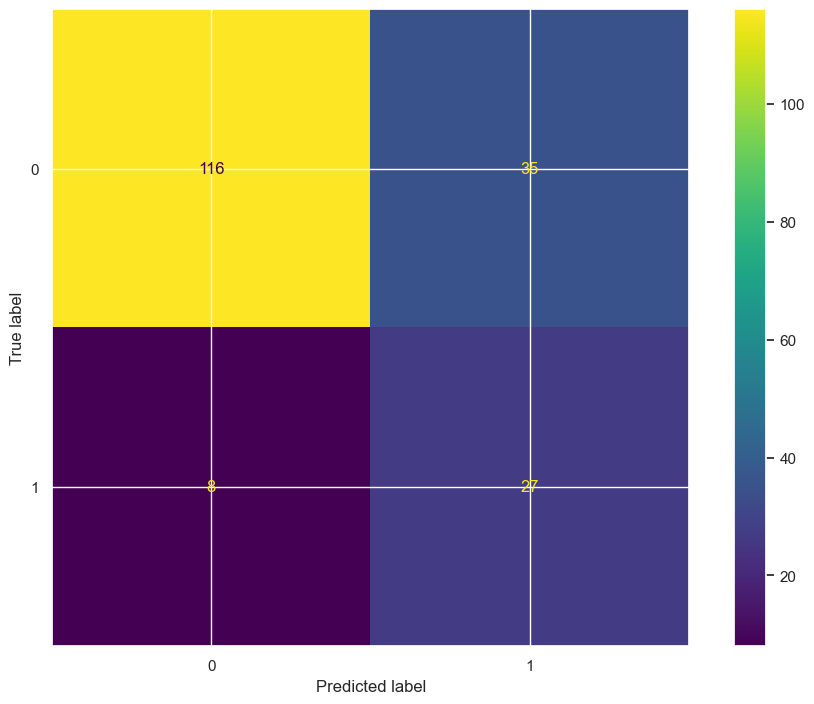

<Figure size 100x100 with 0 Axes>

Fold run (k=5)


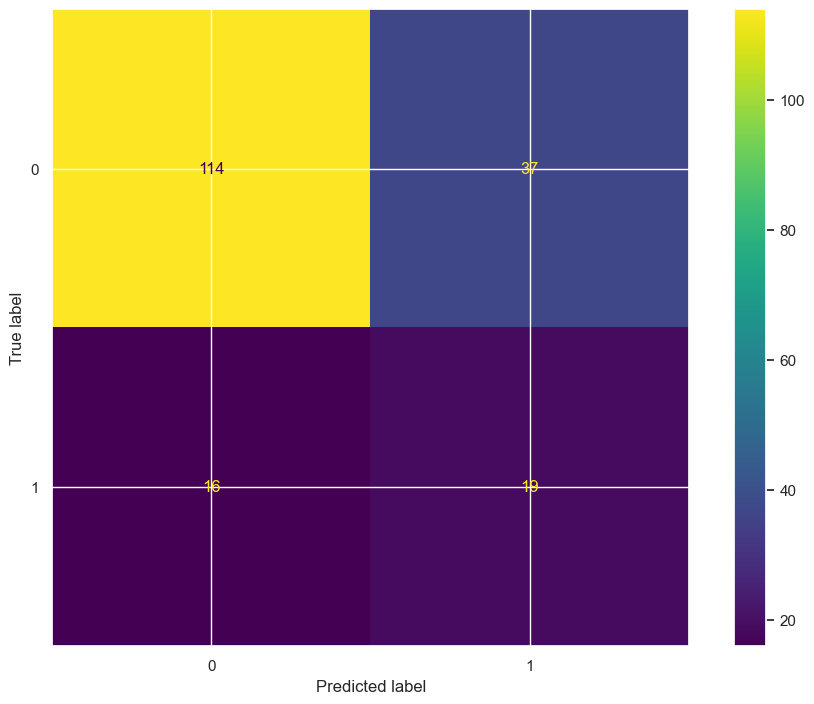

<Figure size 100x100 with 0 Axes>

Fold run (k=6)


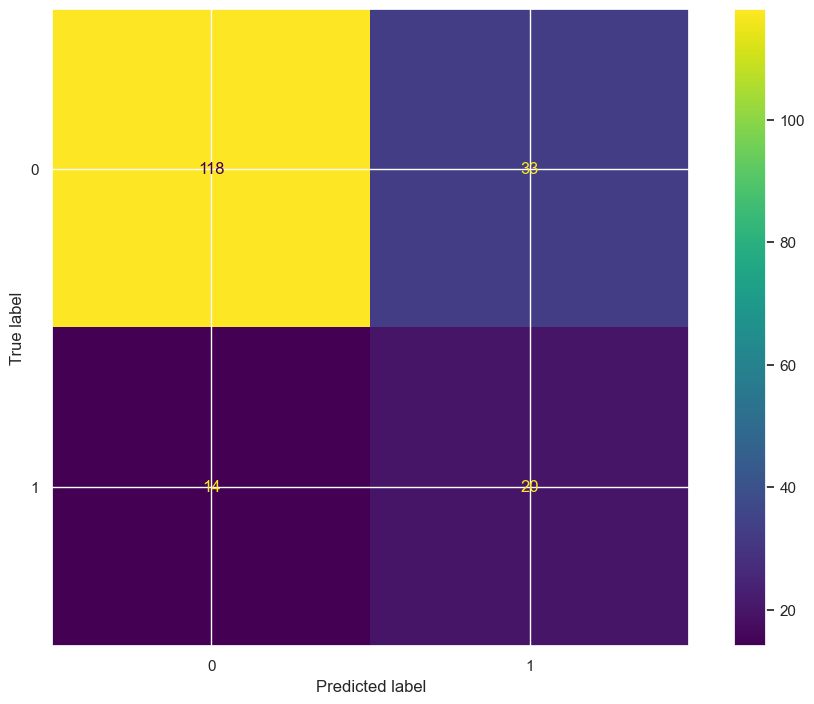

<Figure size 100x100 with 0 Axes>

Fold run (k=7)


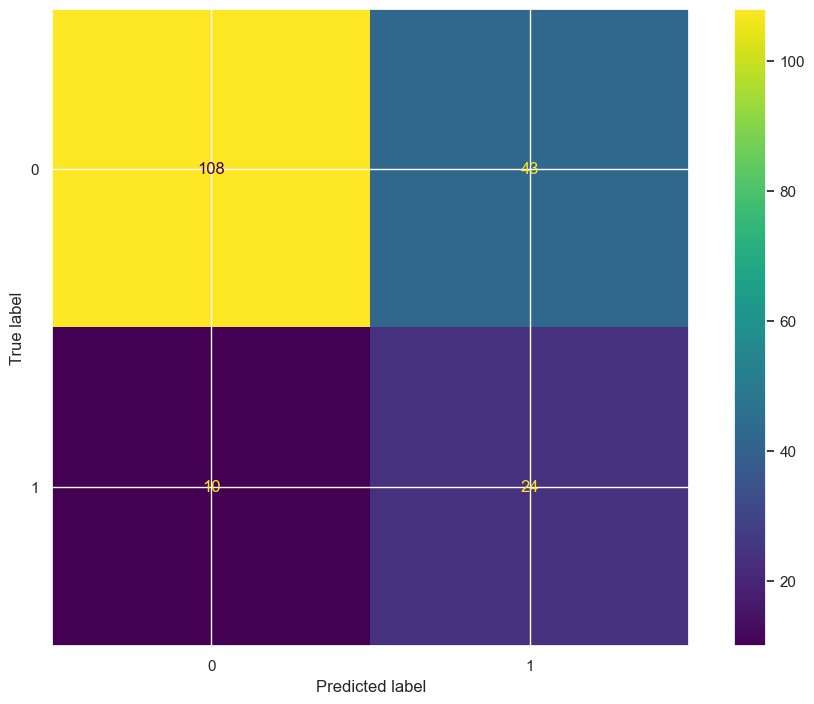

<Figure size 100x100 with 0 Axes>

Fold run (k=8)


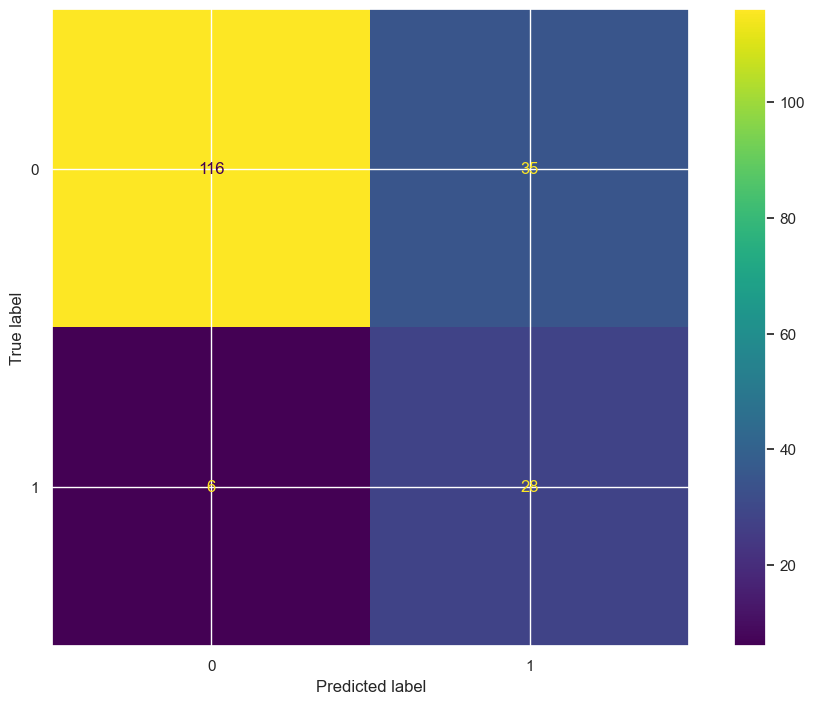

<Figure size 100x100 with 0 Axes>

Fold run (k=9)


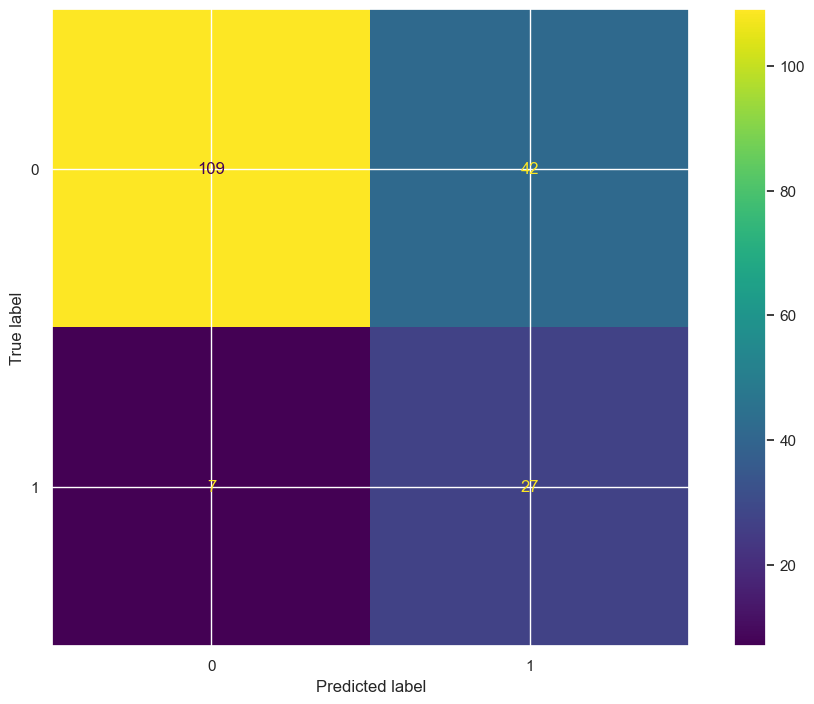

<Figure size 100x100 with 0 Axes>

   Count_k  Accuracy_score  F1 score  Precision score  Recall score
0        0        0.661290  0.694063         0.753583      0.661290
1        1        0.741935  0.760821         0.792517      0.741935
2        2        0.774194  0.788883         0.814824      0.774194
3        3        0.725806  0.742835         0.768359      0.725806
4        4        0.768817  0.789643         0.841398      0.768817
5        5        0.715054  0.737285         0.775755      0.715054
6        6        0.745946  0.765159         0.799000      0.745946
7        7        0.713514  0.742743         0.812878      0.713514
8        8        0.778378  0.799736         0.857756      0.778378
9        9        0.735135  0.762776         0.838877      0.735135


In [30]:
#Train model with tuned hyperparameters. Random state is set
pines = RandomForestClassifier(criterion="log_loss",max_depth=9,min_samples_leaf=2,random_state=42)
pines.fit(X_train,y_train)
#Predicts label values 
y_test_predicted = pines.predict(X_test)
#Defines feature and prediction dataframes to initizialize a Stratified K fold simulation. 
X_tot = raw_df.iloc[:,:-1]
X_missFeat= X_tot.drop(columns=["health_gen",'chol_check','fruits', 'vegetables'])
y = raw_df["disease"]
#Carrys out model evaluation
metrics_RFC = strat_valid(X_missFeat,y,pines, categories=['gender', 'high_chol', "walking_diff", 'history_stroke', 'history_heart_disease', 'amount_activity', 'high_bp'],numerical=['age', 'bmi','health_ment', 'health_phys',"alcohol_misuse"])
print(metrics_RFC)


**Decision tree Classifier** Another supervised learning method as a test.

In [78]:
#Randomly determines Decision tree hyper-parameters and checks all possible combinations to use. 
parameters = {
    'criterion':('gini', 'entropy'), 
    'max_depth':[1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf':[2,5,6,7,8,10,11],
    "max_features":("sqrt", "log2")
}
#define DecisionTree model and determine best hyperparameters with GridSearchCV. 
oak = DecisionTreeClassifier(random_state=42)
oak.fit(X_train,y_train)
oak_gsearch = GridSearchCV(oak, parameters, cv=5,scoring='balanced_accuracy') # weighted == F1 Measure for multi-class
grid_search = oak_gsearch.fit(X_train, y_train)

#Outputs best parameter from grid search estimation. 
oak_gsearch.best_estimator_

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                       random_state=42)

Fold run (k=0)


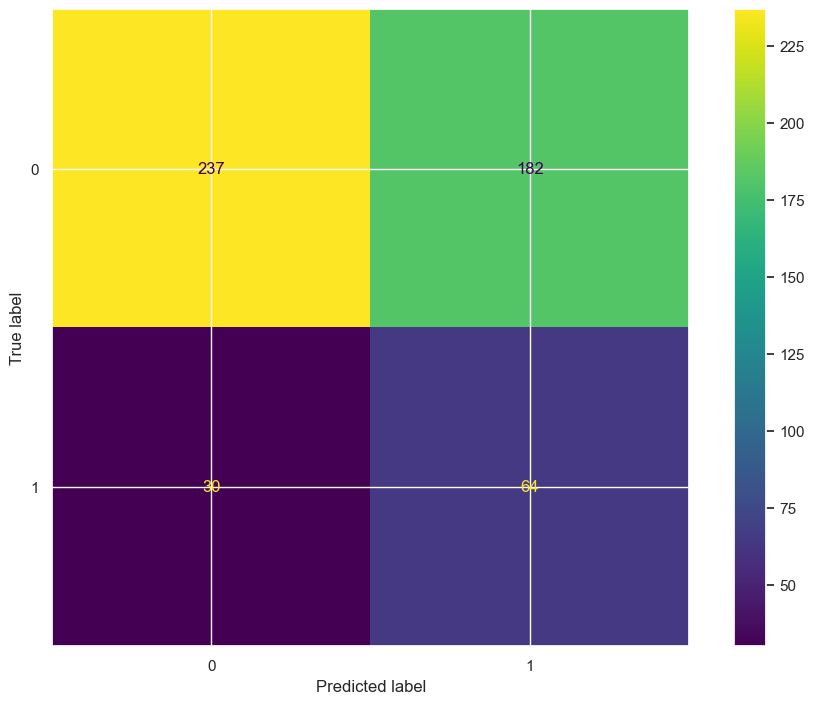

<Figure size 100x100 with 0 Axes>

Fold run (k=1)


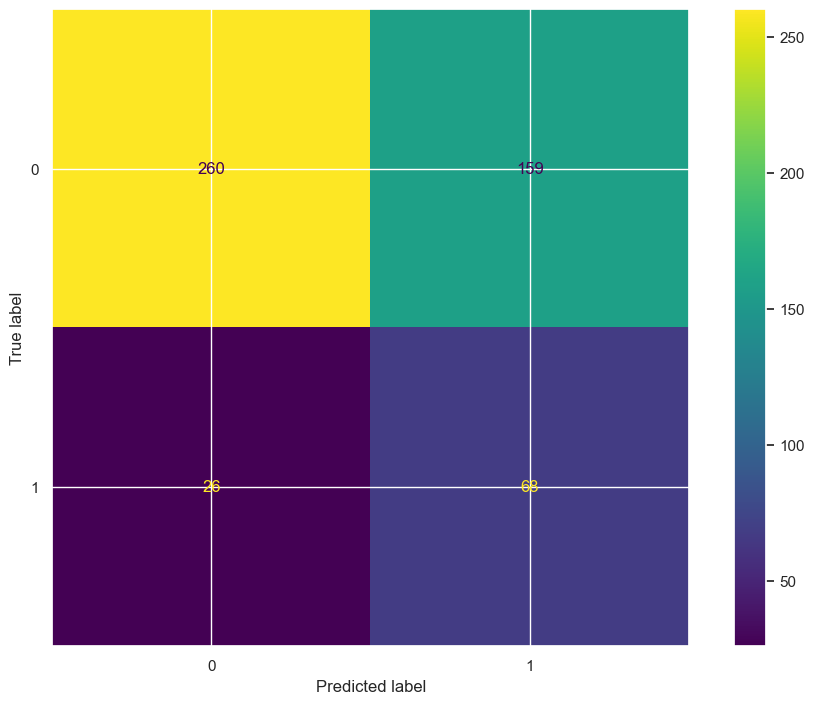

<Figure size 100x100 with 0 Axes>

Fold run (k=2)


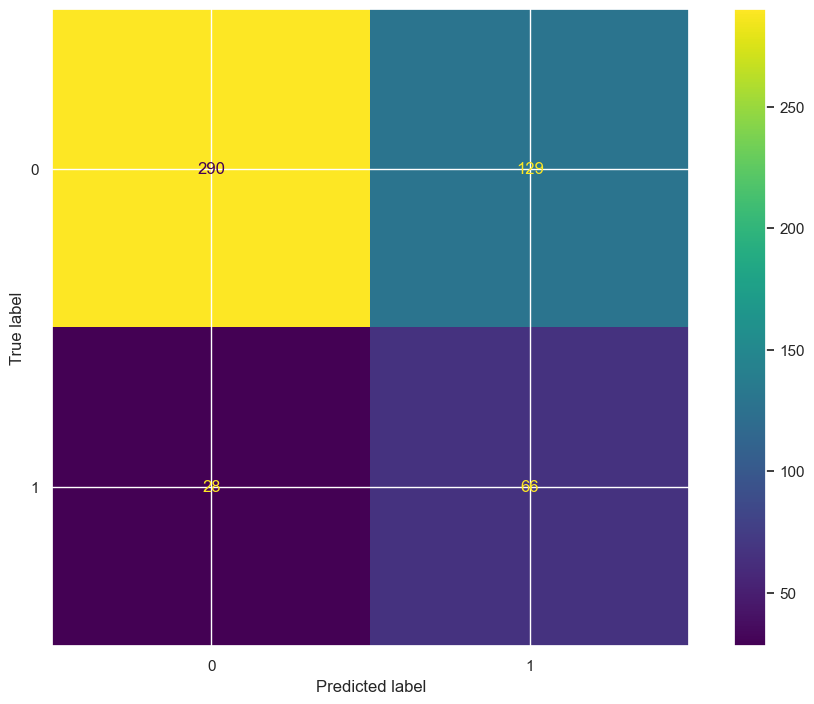

<Figure size 100x100 with 0 Axes>

Fold run (k=3)


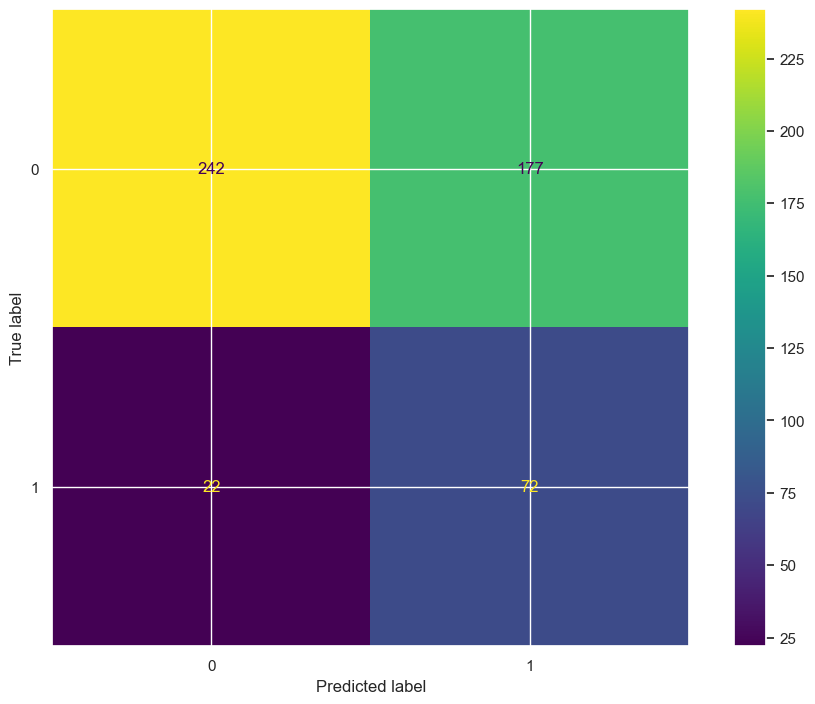

<Figure size 100x100 with 0 Axes>

Fold run (k=4)


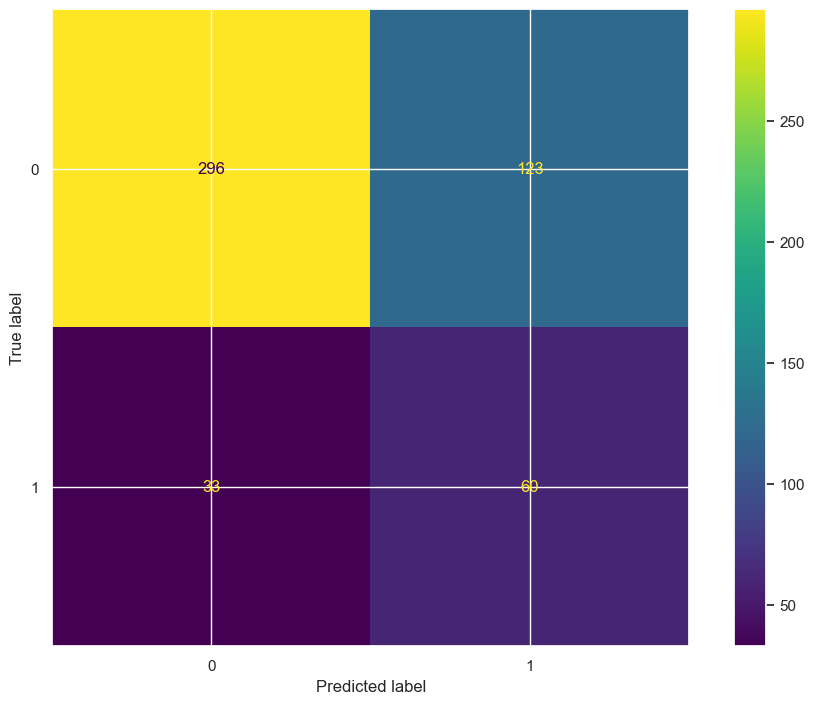

<Figure size 100x100 with 0 Axes>

Fold run (k=5)


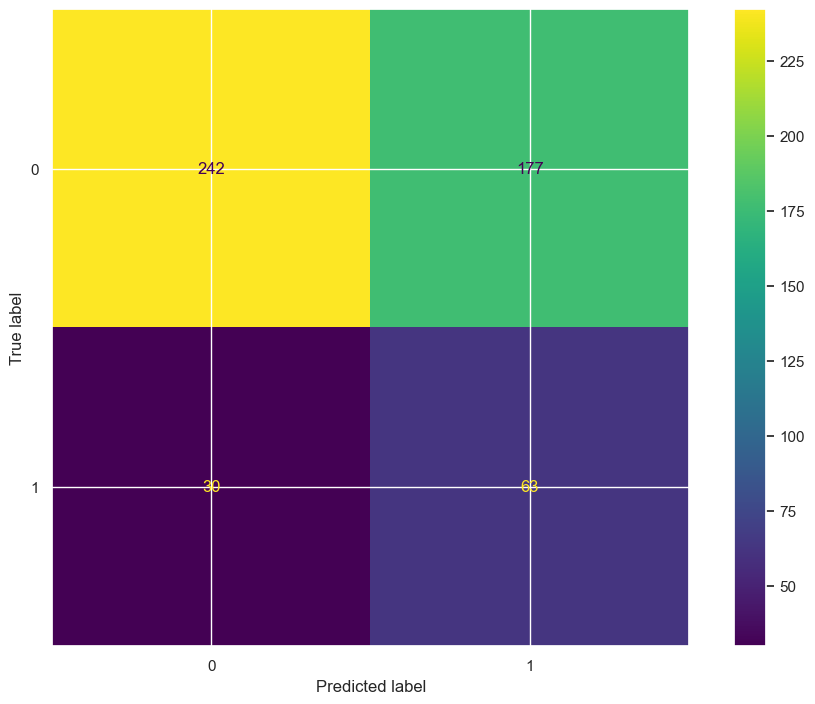

<Figure size 100x100 with 0 Axes>

Fold run (k=6)


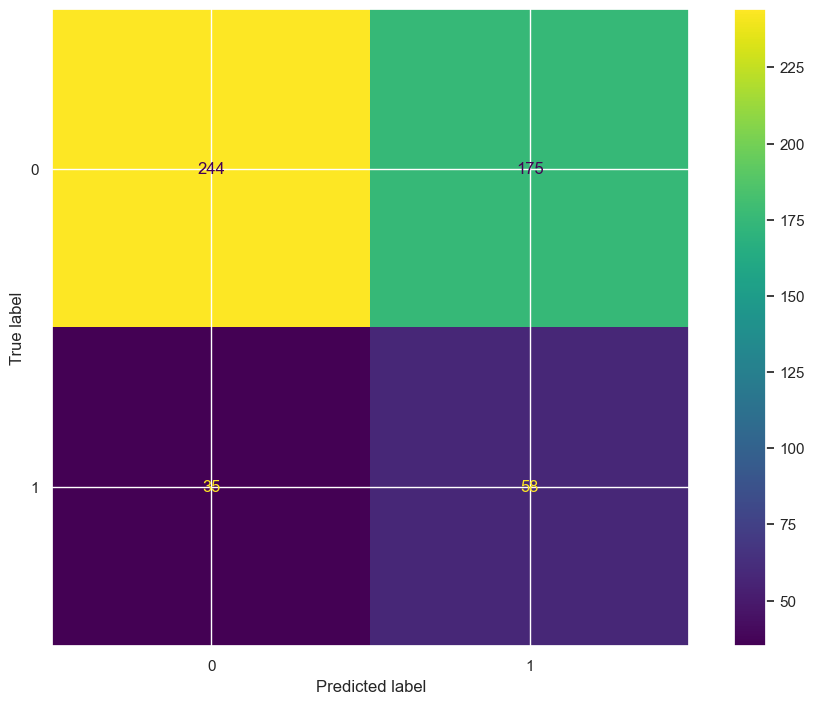

<Figure size 100x100 with 0 Axes>

Fold run (k=7)


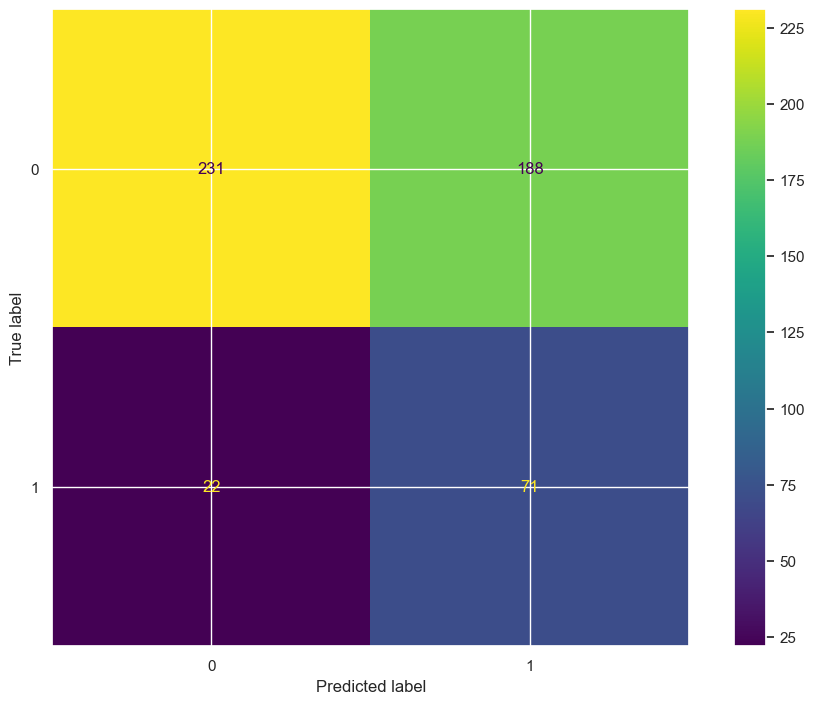

<Figure size 100x100 with 0 Axes>

Fold run (k=8)


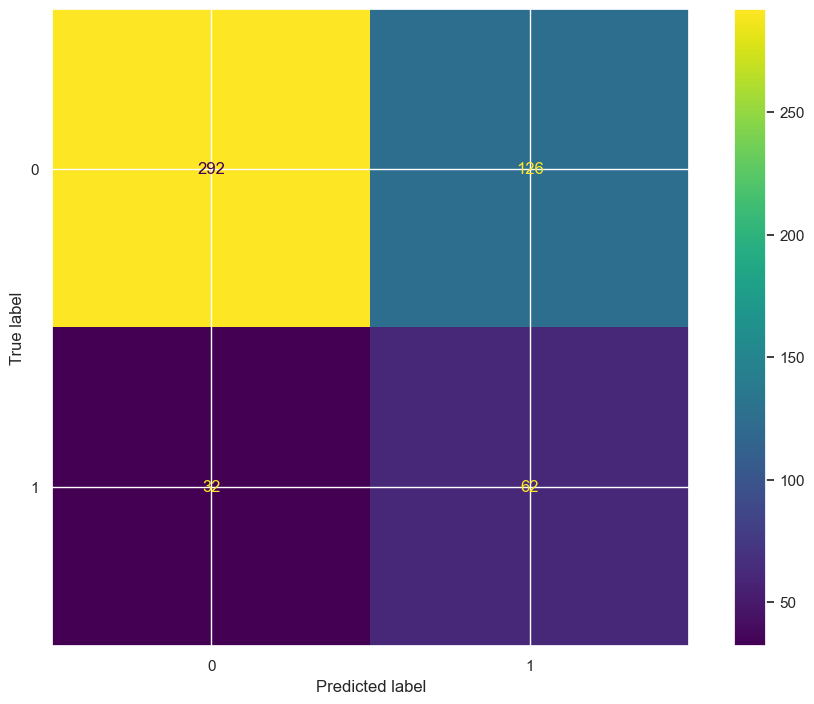

<Figure size 100x100 with 0 Axes>

Fold run (k=9)


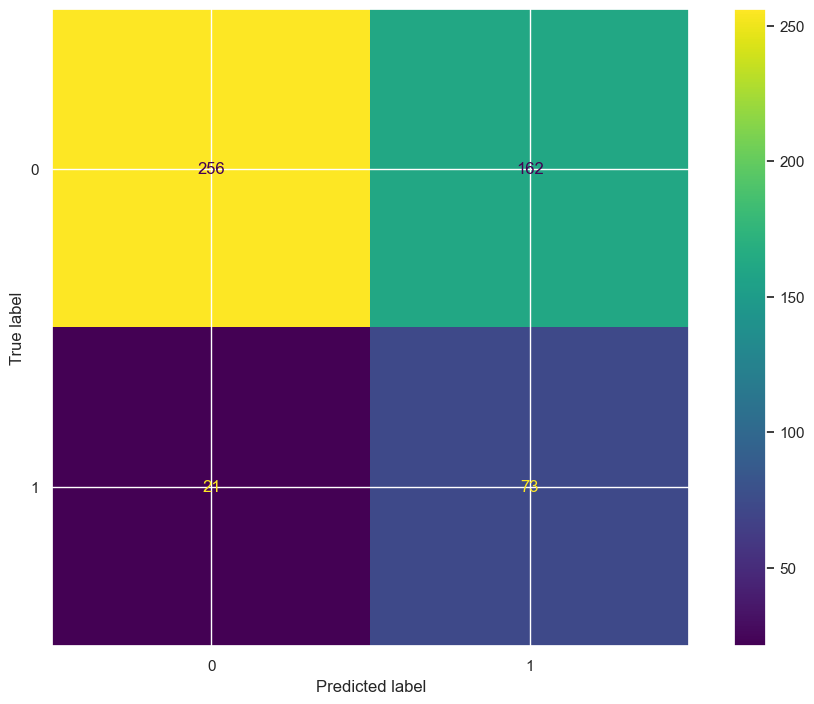

<Figure size 100x100 with 0 Axes>

,Count_k,Accuracy_score,F1 score,Precision score,Recall score
0,0,0.586745,0.633336,0.772664,0.586745
1,1,0.639376,0.680069,0.797403,0.639376
2,2,0.693957,0.726465,0.806866,0.693957
3,3,0.612086,0.655717,0.801684,0.612086
4,4,0.695312,0.726660,0.795829,0.695312
5,5,0.595703,0.641936,0.775780,0.595703
6,6,0.589844,0.636781,0.760913,0.589844
7,7,0.589844,0.635898,0.796991,0.589844
8,8,0.691406,0.723291,0.796320,0.691406
9,9,0.642578,0.682912,0.811544,0.642578


In [79]:
oak = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',min_samples_leaf=6, random_state=42)
oak.fit(X_train,y_train)
#tree.plot_tree(oak)
y_test_predicted = oak.predict(X_test)

X_DT = raw_df.iloc[:,:-1]
y_DT = raw_df["disease"]

#Carries cross validation (see previouslt defined function). 
metrics_DTC = strat_valid(X_DT, y_DT, oak)
metrics_DTC

Text(0.5, 0, 'Feature importance')

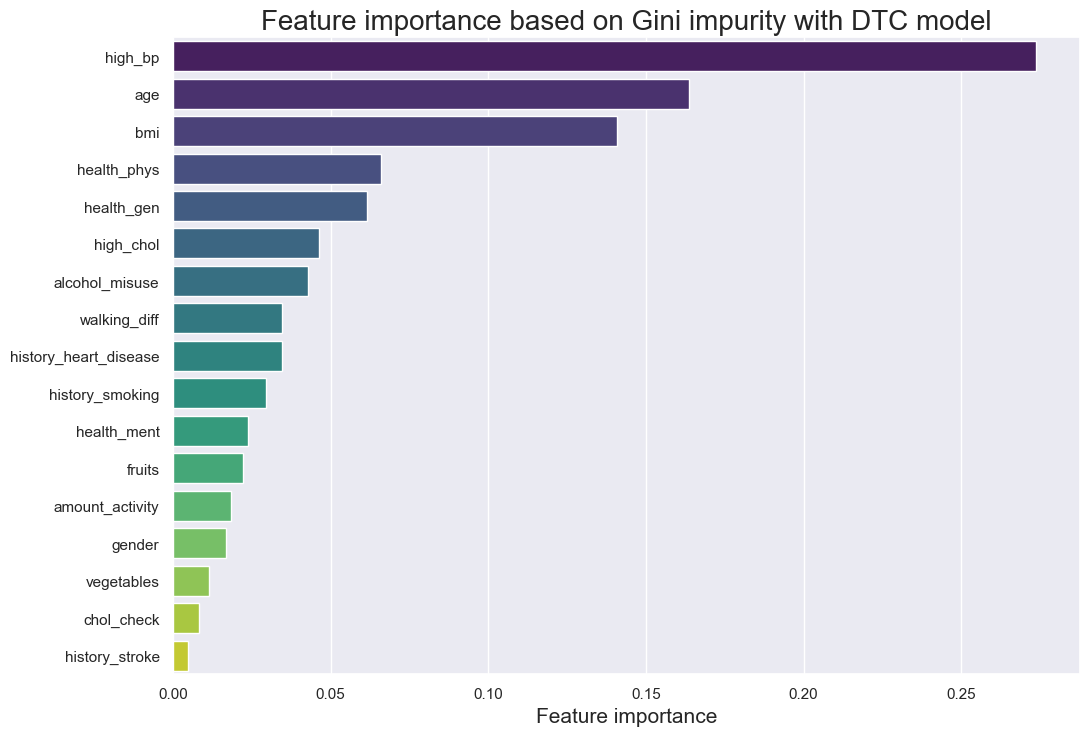

In [75]:
#Determines feature importance based on DTC model
ft_import = oak.feature_importances_

#Sorts features from most important to least important.
sorted_idx = ft_import.argsort()[::-1]
name_sort = imputed_df.columns[sorted_idx]
importa_sort = ft_import[sorted_idx]

#Plot importances 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=importa_sort, y=name_sort, palette="viridis")
plt.title("Feature importance based on Gini impurity with DTC model", fontsize= 20)
plt.xlabel("Feature importance", fontsize= 15)

**Removing most important feature for Decision Tree Classifier** 

According to Gini impurity reduction score, the most important feature is high blood pressure, which contributes to ~27% for the reduction of gene impurity.

In [80]:
#Randomly determines Decision tree hyper-parameters and checks all possible combinations to use. 
parameters = {
    'criterion':('gini', 'entropy'), 
    'max_depth':[1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf':[2,5,6,7,8,10,11],
    "max_features":("sqrt", "log2")
}
#define DecisionTree model and determine best hyperparameters with GridSearchCV. 
oak = DecisionTreeClassifier(random_state=42)
oak.fit(X_train.drop(columns=["high_bp"]),y_train)
oak_gsearch = GridSearchCV(oak, parameters, cv=5,scoring='balanced_accuracy') # weighted == F1 Measure for multi-class
grid_search = oak_gsearch.fit(X_train.drop(columns=["high_bp"]), y_train)

#Outputs best parameter from grid search estimation. 
oak_gsearch.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       min_samples_leaf=7, random_state=42)

Fold run (k=0)


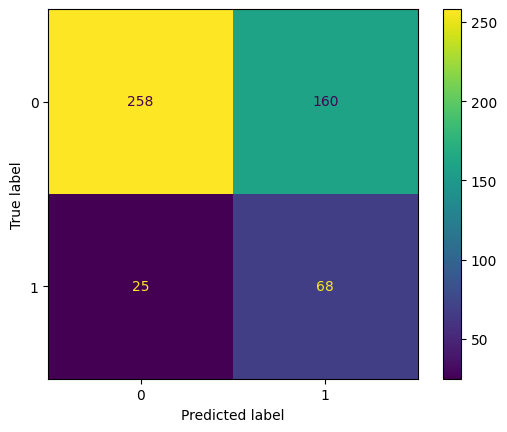

<Figure size 100x100 with 0 Axes>

Fold run (k=1)


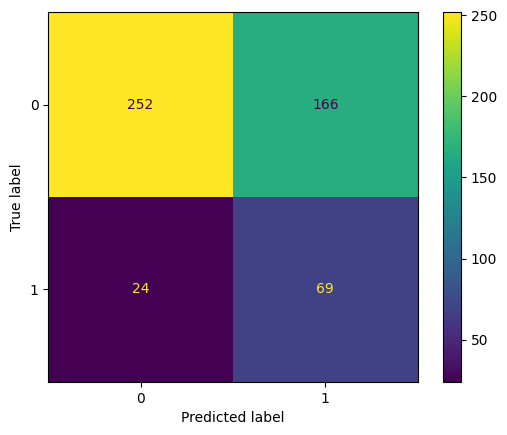

<Figure size 100x100 with 0 Axes>

Fold run (k=2)


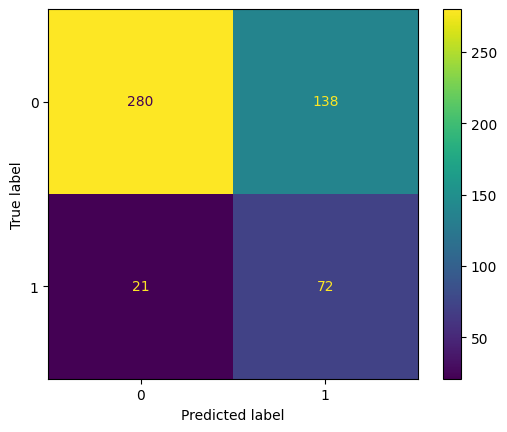

<Figure size 100x100 with 0 Axes>

Fold run (k=3)


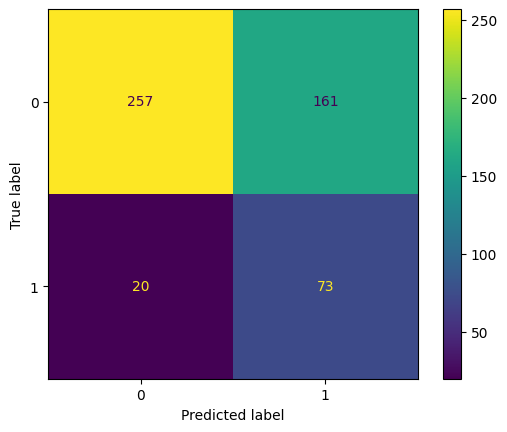

<Figure size 100x100 with 0 Axes>

Fold run (k=4)


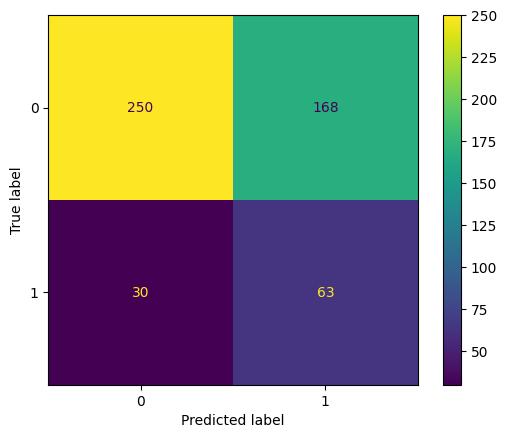

<Figure size 100x100 with 0 Axes>

Fold run (k=5)


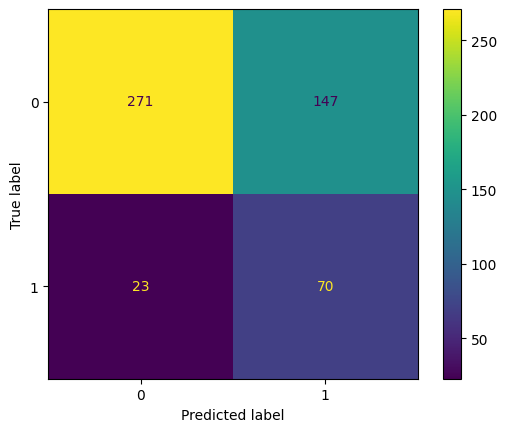

<Figure size 100x100 with 0 Axes>

Fold run (k=6)


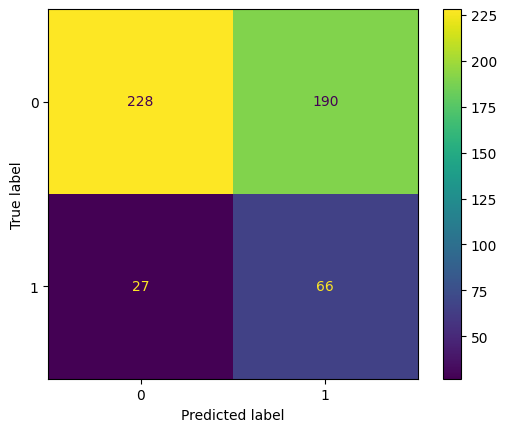

<Figure size 100x100 with 0 Axes>

Fold run (k=7)


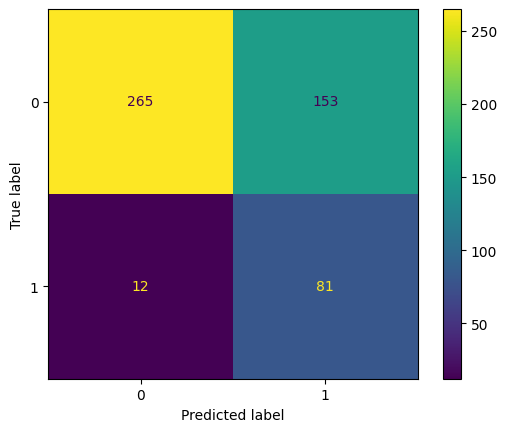

<Figure size 100x100 with 0 Axes>

Fold run (k=8)


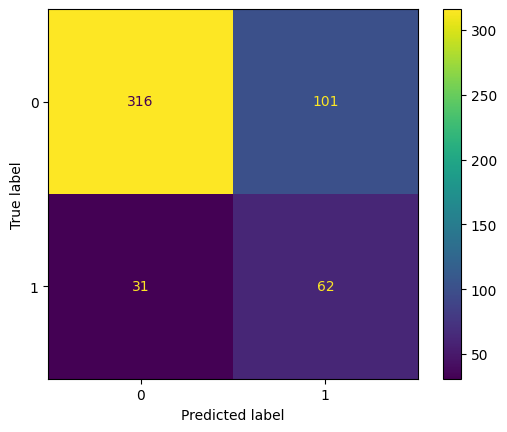

<Figure size 100x100 with 0 Axes>

Fold run (k=9)


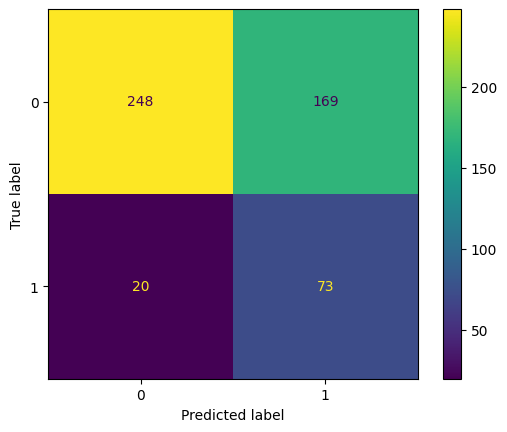

<Figure size 100x100 with 0 Axes>

,Count_k,Accuracy_score,F1 score,Precision score,Recall score
0,0,0.637965,0.679233,0.800022,0.637965
1,1,0.628180,0.670626,0.800310,0.628180
2,2,0.688845,0.723603,0.823333,0.688845
3,3,0.645793,0.686228,0.815719,0.645793
4,4,0.612524,0.656739,0.779996,0.612524
5,5,0.667319,0.704886,0.812719,0.667319
6,6,0.575342,0.623085,0.778313,0.575342
7,7,0.677104,0.713965,0.845566,0.677104
8,8,0.741176,0.764705,0.813962,0.741176
9,9,0.629412,0.671521,0.811636,0.629412


In [38]:
oak = DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='sqrt',min_samples_leaf=7, random_state=42)
oak.fit(X_train.drop(columns=["high_bp"]),y_train)
#tree.plot_tree(oak)
y_test_predicted = oak.predict(X_test.drop(columns=["high_bp"]))

X_DT = raw_df.iloc[:,:-1]
y_DT = raw_df["disease"]

#Carries cross validation (see previouslt defined function). 
rm_ft_metrics = strat_valid(X_DT.drop(columns=["high_bp"]), y_DT, oak, 
                            categories= ['gender', 'high_chol', "walking_diff",'chol_check', 'history_stroke', 'history_heart_disease', 'amount_activity', 'fruits', 'vegetables'], 
                            numerical=[ 'health_gen', 'health_ment', 'health_phys',"alcohol_misuse"])
rm_ft_metrics